#### Import necessary libraries

In [37]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import os
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
import pickle
import joblib
import sklearn
import scipy
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor
import pickle
import joblib
from utils import *
%matplotlib inline

Multiplying ABC Scores * Predicted accessibility output to get final inputs

In [4]:

import pickle
def make_gene_dictionary(embeddings_file, outfile):
    constant_scores = pd.read_csv("/mnt/lab_data2/kmualim/enh-gene-linking/datasets/embeddings/new_version/constant_promoter_weights/constantweightedpromoters_abc.csv", sep="\t", header=None)
    genes = constant_scores.iloc[:,3]
    scores = (constant_scores.iloc[:,4]).ravel()
    len(genes)
    # 23609 genes total

    embeddings = np.load(embeddings_file)['arr_0']
    embeddings_scores = [i*j for i,j in zip(scores, embeddings)]

    gene_dictionary = {}
    for i in genes.drop_duplicates():
        print("Gene: ", i)
        indices = genes.loc[genes==i].index.astype(int)
        total_scores = [embeddings_scores[i] for i in indices]
        gene_dictionary[i] = np.sum(total_scores, axis=0)

    with open(outfile, 'wb') as fp:
        pickle.dump(gene_dictionary, fp)

<a id='loadinput'></a>
#### Load input files 

In [39]:
expression = pd.read_csv("/users/kmualim/updated_ABC/github/ABC-Enhancer-Gene-Prediction/example_chr22/input_data/Expression/K562.ENCFF934YBO.TPM.txt", sep="\t", header=None)
labels = pd.read_csv("gene_labels.txt", sep="\t", header=None)
gene_labels = list(labels[0])

In [4]:

gene_dictionary = pickle.load(open("ConstantEnhancerPromoter_BassetRegressionLabels.p", "rb"))

<a id='dataprocessing'></a>
#### Functions for combining and splitting data inputs 

In [41]:
## Appending labels to expression table 
## 0 for non-expressed, 0 for expressed
label_1=[]
for i in expression[1]: 
    if i>1: 
        label_1.append(1)
    else: 
        label_1.append(0)

expression[2] = label_1

<a id='datafiles'></a>
#### Data files and corresponding names

In [20]:
weighted_gene_dictionary = pickle.load(open("ConstantEnhancerPromoter_BassetRegressionLabels.p", "rb"))

In [21]:
x_train, x_valid, x_test, y_train_regression_labels, y_valid_regression_labels, y_test_regression_labels,\
y_train_classif_labels, y_valid_classif_labels, y_test_classif_labels, y_train_gene_labels, y_valid_gene_labels, y_test_gene_labels = \
get_train_valid_split(gene_labels, weighted_gene_dictionary, expression, classify=True)


Y Train:  18887
Y valid:  3541
Y test:  1181
Y Train El 18887
Y Train El 3541
Y Train El 1181
Y Train labels: 15850
Y valid labels: 3039
Y Test labels: 992
X Train labels: 15850
X valid labels: 3039
X test labels: 992
Y Train C: 15850
Y Valid C: 3039
Y Test C: 992
Y Train R: 15850
Y Valid R: 3039
Y Test R: 992


In [24]:
unweighted_gene_dictionary = pickle.load(open("ConstantEnhancerPromoter_UNWEIGHTEDBassetRegressionLabels.p", "rb"))

x_train, x_valid, x_test, y_train_regression_labels, y_valid_regression_labels, y_test_regression_labels,\
y_train_classif_labels, y_valid_classif_labels, y_test_classif_labels, y_train_gene_labels, y_valid_gene_labels, y_test_gene_labels = \
get_train_valid_split(gene_labels, unweighted_gene_dictionary, expression, classify=True)


Y Train:  18887
Y valid:  3541
Y test:  1181
Y Train El 18887
Y Train El 3541
Y Train El 1181
Y Train labels: 15850
Y valid labels: 3039
Y Test labels: 992
X Train labels: 15850
X valid labels: 3039
X test labels: 992
Y Train C: 15850
Y Valid C: 3039
Y Test C: 992
Y Train R: 15850
Y Valid R: 3039
Y Test R: 992


In [14]:
def plot(y_valid_preds, y_valid): 
    print("Spearman R", scipy.stats.spearmanr(y_valid_preds,np.arcsinh(y_valid)))
    print("Pearson R", scipy.stats.pearsonr(y_valid_preds,np.arcsinh(y_valid)))
    plt.plot(y_valid_preds, np.arcsinh(y_valid), 'ro', markersize=2)
    plt.xlabel('Predictions')
    plt.ylabel('Actual')
    plt.title('Pearsonr: 0.194, Spearmanr: 0.180')
    plt.xlim(-5, 6)
    
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - np.arcsinh(test_labels))
    plot(predictions, test_labels)
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    return predictions, errors 

<a id='linearbase'></a>
### Linear Regression 
-- using predicted accessibility as sequence features 

Spearman R SpearmanrResult(correlation=0.5141989774910881, pvalue=0.0)
Pearson R (0.465857126588285, 0.0)
Model Performance
Average Error: 1.5099 degrees.


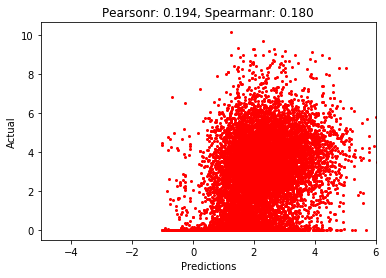

In [22]:
linearRegression = LinearRegression()
linearRegression.fit(x_train, np.arcsinh(y_train_regression_labels))
reweighted_predictions, _ = evaluate(linearRegression, x_train, y_train_regression_labels)

Spearman R SpearmanrResult(correlation=0.5213977051550586, pvalue=1.6613285013802764e-211)
Pearson R (0.47225918999750527, 1.1639291122212523e-168)
Model Performance
Average Error: 1.5032 degrees.


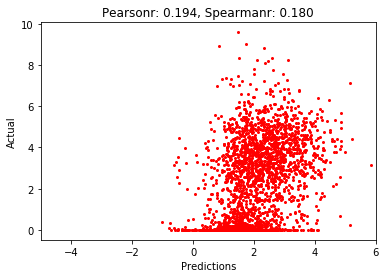

In [23]:
reweighted_predictions = evaluate(linearRegression, x_valid, y_valid_regression_labels)

unweighted predicted accessibility -- just using the predicted accessibility as sequence features

Spearman R SpearmanrResult(correlation=0.14035548912036808, pvalue=1.5250441379484192e-70)
Pearson R (0.12723090309444685, 3.406804953209125e-58)
Model Performance
Average Error: 1.8118 degrees.


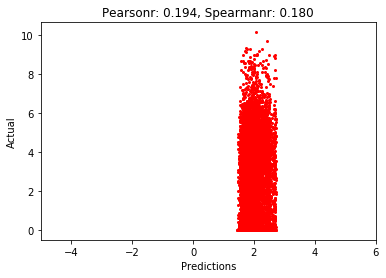

In [25]:
linearRegression = LinearRegression()
linearRegression.fit(x_train, np.arcsinh(y_train_regression_labels))
unweighted_predictions, _ = evaluate(linearRegression, x_train, y_train_regression_labels)

Spearman R SpearmanrResult(correlation=0.15168483784495876, pvalue=4.199226093275446e-17)
Pearson R (0.12338600709315396, 8.779581228302442e-12)
Model Performance
Average Error: 1.8109 degrees.


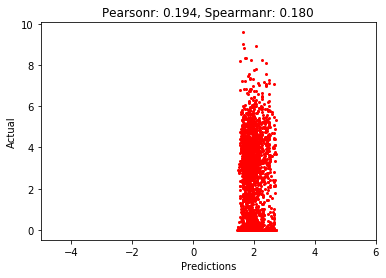

In [26]:
unweighted_predictions, _ = evaluate(linearRegression, x_valid, y_valid_regression_labels)

### Using H3K27ac acetylation signal as sequence features 

In [ ]:
make_gene_dictionary("ConstantPromoterEnhancer_h3K27ac_predicted_deepsea.npz", "ConstantPromoterEnhancer_H3k27ac_predicted_deepsea.p")

Gene:  DDX11L1
Gene:  WASH7P
Gene:  FAM138A
Gene:  FAM138F
Gene:  OR4F5
Gene:  LOC729737
Gene:  LOC101928626
Gene:  LOC100288069
Gene:  FAM87B
Gene:  LINC00115
Gene:  LINC01128
Gene:  FAM41C
Gene:  LOC100130417
Gene:  SAMD11
Gene:  NOC2L
Gene:  KLHL17
Gene:  PLEKHN1
Gene:  PERM1
Gene:  HES4
Gene:  ISG15
Gene:  AGRN
Gene:  RNF223
Gene:  C1orf159
Gene:  LINC01342
Gene:  TTLL10
Gene:  TNFRSF18
Gene:  TNFRSF4
Gene:  SDF4
Gene:  B3GALT6
Gene:  C1QTNF12
Gene:  UBE2J2
Gene:  SCNN1D
Gene:  ACAP3
Gene:  PUSL1
Gene:  INTS11
Gene:  CPTP
Gene:  TAS1R3
Gene:  DVL1
Gene:  MXRA8
Gene:  AURKAIP1
Gene:  CCNL2
Gene:  LOC148413
Gene:  MRPL20
Gene:  ANKRD65
Gene:  TMEM88B
Gene:  LINC01770
Gene:  VWA1
Gene:  ATAD3C
Gene:  ATAD3B
Gene:  ATAD3A
Gene:  TMEM240
Gene:  SSU72
Gene:  FNDC10
Gene:  MIB2
Gene:  MMP23B
Gene:  SLC35E2B
Gene:  CDK11B
Gene:  CDK11A
Gene:  SLC35E2
Gene:  NADK
Gene:  GNB1
Gene:  CALML6
Gene:  TMEM52
Gene:  CFAP74
Gene:  GABRD
Gene:  LOC105378591
Gene:  PRKCZ
Gene:  FAAP20
Gene:  SKI
Gene

Gene:  GNL2
Gene:  RSPO1
Gene:  C1orf109
Gene:  CDCA8
Gene:  EPHA10
Gene:  MANEAL
Gene:  C1orf122
Gene:  YRDC
Gene:  MTF1
Gene:  INPP5B
Gene:  SF3A3
Gene:  FHL3
Gene:  UTP11
Gene:  POU3F1
Gene:  LINC01343
Gene:  RRAGC
Gene:  MYCBP
Gene:  LOC105378663
Gene:  GJA9
Gene:  GJA9-MYCBP
Gene:  RHBDL2
Gene:  AKIRIN1
Gene:  NDUFS5
Gene:  MACF1
Gene:  KIAA0754
Gene:  BMP8A
Gene:  OXCT2P1
Gene:  PPIEL
Gene:  LOC101929516
Gene:  PABPC4
Gene:  HEYL
Gene:  NT5C1A
Gene:  HPCAL4
Gene:  PPIE
Gene:  OXCT2
Gene:  BMP8B
Gene:  LOC101929536
Gene:  TRIT1
Gene:  MYCL
Gene:  MFSD2A
Gene:  CAP1
Gene:  PPT1
Gene:  RLF
Gene:  TMCO2
Gene:  ZMPSTE24
Gene:  COL9A2
Gene:  SMAP2
Gene:  ZFP69B
Gene:  ZFP69
Gene:  EXO5
Gene:  ZNF684
Gene:  RIMS3
Gene:  NFYC
Gene:  NFYC-AS1
Gene:  KCNQ4
Gene:  CITED4
Gene:  CTPS1
Gene:  SLFNL1-AS1
Gene:  SLFNL1
Gene:  SCMH1
Gene:  FOXO6
Gene:  LOC101929901
Gene:  EDN2
Gene:  HIVEP3
Gene:  GUCA2B
Gene:  GUCA2A
Gene:  FOXJ3
Gene:  RIMKLA
Gene:  ZMYND12
Gene:  PPCS
Gene:  CCDC30
Gene:  PPI

Gene:  LOC440600
Gene:  RBM15
Gene:  SLC16A4
Gene:  LAMTOR5-AS1
Gene:  LAMTOR5
Gene:  PROK1
Gene:  CYMP
Gene:  CYMP-AS1
Gene:  KCNA10
Gene:  KCNA2
Gene:  KCNA3
Gene:  CD53
Gene:  LRIF1
Gene:  CEPT1
Gene:  DRAM2
Gene:  DENND2D
Gene:  CHI3L2
Gene:  CHIAP2
Gene:  CHIA
Gene:  PIFO
Gene:  PGCP1
Gene:  OVGP1
Gene:  ATP5F1
Gene:  WDR77
Gene:  C1orf162
Gene:  ADORA3
Gene:  TMIGD3
Gene:  LINC01160
Gene:  RAP1A
Gene:  FAM212B
Gene:  FAM212B-AS1
Gene:  LOC101928718
Gene:  DDX20
Gene:  KCND3-IT1
Gene:  KCND3-AS1
Gene:  KCND3
Gene:  LINC01750
Gene:  CTTNBP2NL
Gene:  WNT2B
Gene:  ST7L
Gene:  CAPZA1
Gene:  MOV10
Gene:  RHOC
Gene:  PPM1J
Gene:  FAM19A3
Gene:  LINC01356
Gene:  AKR7A2P1
Gene:  SLC16A1
Gene:  SLC16A1-AS1
Gene:  LOC100996251
Gene:  LRIG2
Gene:  LOC643441
Gene:  MAGI3
Gene:  PHTF1
Gene:  RSBN1
Gene:  AP4B1-AS1
Gene:  PTPN22
Gene:  BCL2L15
Gene:  AP4B1
Gene:  DCLRE1B
Gene:  HIPK1-AS1
Gene:  HIPK1
Gene:  OLFML3
Gene:  SYT6
Gene:  TRIM33
Gene:  BCAS2
Gene:  DENND2C
Gene:  AMPD1
Gene:  NRAS
Ge

Gene:  LOC101928404
Gene:  RGS5
Gene:  NUF2
Gene:  LOC100422212
Gene:  PBX1
Gene:  LOC100505795
Gene:  LMX1A
Gene:  RXRG
Gene:  LRRC52
Gene:  LOC400794
Gene:  MGST3
Gene:  ALDH9A1
Gene:  LOC440700
Gene:  TMCO1
Gene:  LOC100147773
Gene:  UCK2
Gene:  FAM78B
Gene:  FMO9P
Gene:  POGK
Gene:  TADA1
Gene:  ILDR2
Gene:  MAEL
Gene:  GPA33
Gene:  DUSP27
Gene:  LINC01363
Gene:  POU2F1
Gene:  CD247
Gene:  CREG1
Gene:  RCSD1
Gene:  MPZL1
Gene:  ADCY10
Gene:  DCAF6
Gene:  MPC2
Gene:  GPR161
Gene:  TIPRL
Gene:  SFT2D2
Gene:  ANKRD36BP1
Gene:  TBX19
Gene:  LOC100505918
Gene:  LOC101928565
Gene:  XCL2
Gene:  XCL1
Gene:  DPT
Gene:  LINC00626
Gene:  LINC00970
Gene:  LOC101928596
Gene:  ATP1B1
Gene:  BLZF1
Gene:  NME7
Gene:  CCDC181
Gene:  SLC19A2
Gene:  F5
Gene:  SELP
Gene:  SELL
Gene:  SELE
Gene:  METTL18
Gene:  C1orf112
Gene:  SCYL3
Gene:  KIFAP3
Gene:  METTL11B
Gene:  LINC01142
Gene:  GORAB
Gene:  LOC101928650
Gene:  PRRX1
Gene:  MROH9
Gene:  FMO3
Gene:  FMO6P
Gene:  FMO2
Gene:  FMO1
Gene:  FMO4
Gene:

Gene:  DDX1
Gene:  LINC01804
Gene:  MYCNUT
Gene:  MYCN
Gene:  MYCNOS
Gene:  GACAT3
Gene:  FAM49A
Gene:  RAD51AP2
Gene:  VSNL1
Gene:  SMC6
Gene:  GEN1
Gene:  MSGN1
Gene:  KCNS3
Gene:  RDH14
Gene:  NT5C1B-RDH14
Gene:  NT5C1B
Gene:  LINC01376
Gene:  OSR1
Gene:  LINC00954
Gene:  TTC32
Gene:  WDR35
Gene:  LOC101928222
Gene:  MATN3
Gene:  LAPTM4A
Gene:  SDC1
Gene:  PUM2
Gene:  RHOB
Gene:  HS1BP3-IT1
Gene:  HS1BP3
Gene:  GDF7
Gene:  LDAH
Gene:  APOB
Gene:  TDRD15
Gene:  LINC01822
Gene:  LINC01884
Gene:  KLHL29
Gene:  ATAD2B
Gene:  UBXN2A
Gene:  MFSD2B
Gene:  WDCP
Gene:  FKBP1B
Gene:  SF3B6
Gene:  FAM228B
Gene:  TP53I3
Gene:  PFN4
Gene:  FAM228A
Gene:  ITSN2
Gene:  NCOA1
Gene:  CENPO
Gene:  PTRHD1
Gene:  ADCY3
Gene:  DNAJC27
Gene:  DNAJC27-AS1
Gene:  EFR3B
Gene:  POMC
Gene:  LINC01381
Gene:  DNMT3A
Gene:  DTNB
Gene:  ASXL2
Gene:  KIF3C
Gene:  RAB10
Gene:  GAREM2
Gene:  HADHA
Gene:  HADHB
Gene:  SELENOI
Gene:  ADGRF3
Gene:  DRC1
Gene:  OTOF
Gene:  C2orf70
Gene:  CIB4
Gene:  KCNK3
Gene:  SLC35F6

Gene:  FAHD2B
Gene:  ANKRD36
Gene:  LOC100506123
Gene:  ANKRD36B
Gene:  COX5B
Gene:  ACTR1B
Gene:  LINC01125
Gene:  ZAP70
Gene:  TMEM131
Gene:  VWA3B
Gene:  CNGA3
Gene:  INPP4A
Gene:  COA5
Gene:  UNC50
Gene:  MGAT4A
Gene:  LOC101927070
Gene:  KIAA1211L
Gene:  C2orf15
Gene:  LIPT1
Gene:  TSGA10
Gene:  MITD1
Gene:  MRPL30
Gene:  LYG2
Gene:  LYG1
Gene:  TXNDC9
Gene:  EIF5B
Gene:  REV1
Gene:  AFF3
Gene:  LINC01104
Gene:  LONRF2
Gene:  CHST10
Gene:  NMS
Gene:  PDCL3
Gene:  NPAS2
Gene:  LOC101927142
Gene:  RPL31
Gene:  TBC1D8
Gene:  TBC1D8-AS1
Gene:  CNOT11
Gene:  RNF149
Gene:  CREG2
Gene:  RFX8
Gene:  MAP4K4
Gene:  LINC01127
Gene:  IL1R2
Gene:  IL1R1
Gene:  IL1RL2
Gene:  IL1RL1
Gene:  IL18R1
Gene:  IL18RAP
Gene:  SLC9A4
Gene:  SLC9A2
Gene:  MFSD9
Gene:  TMEM182
Gene:  LINC01796
Gene:  LINC01935
Gene:  LOC100287010
Gene:  LINC01831
Gene:  LINC01102
Gene:  LINC01103
Gene:  LINC01114
Gene:  LINC01158
Gene:  POU3F3
Gene:  LINC01159
Gene:  MRPS9
Gene:  LOC102724691
Gene:  UTAT33
Gene:  LINC01918

Gene:  SATB2-AS1
Gene:  LINC01877
Gene:  FTCDNL1
Gene:  C2orf69
Gene:  MAIP1
Gene:  TYW5
Gene:  SPATS2L
Gene:  KCTD18
Gene:  SGO2
Gene:  AOX1
Gene:  AOX3P-AOX2P
Gene:  LINC01792
Gene:  BZW1
Gene:  LOC101927795
Gene:  CLK1
Gene:  PPIL3
Gene:  NIF3L1
Gene:  ORC2
Gene:  FAM126B
Gene:  NDUFB3
Gene:  CFLAR
Gene:  CFLAR-AS1
Gene:  CASP10
Gene:  CASP8
Gene:  ALS2CR12
Gene:  TRAK2
Gene:  STRADB
Gene:  C2CD6
Gene:  TMEM237
Gene:  MPP4
Gene:  ALS2
Gene:  CDK15
Gene:  FZD7
Gene:  KIAA2012
Gene:  LOC729224
Gene:  SUMO1
Gene:  NOP58
Gene:  BMPR2
Gene:  FAM117B
Gene:  ICA1L
Gene:  CARF
Gene:  WDR12
Gene:  NBEAL1
Gene:  CYP20A1
Gene:  ABI2
Gene:  RAPH1
Gene:  CD28
Gene:  CTLA4
Gene:  ICOS
Gene:  PARD3B
Gene:  NRP2
Gene:  INO80D
Gene:  GCSHP3
Gene:  NDUFS1
Gene:  EEF1B2
Gene:  GPR1-AS
Gene:  GPR1
Gene:  ZDBF2
Gene:  ADAM23
Gene:  LOC200726
Gene:  DYTN
Gene:  FASTKD2
Gene:  MDH1B
Gene:  CPO
Gene:  KLF7
Gene:  LOC101927865
Gene:  CREB1
Gene:  METTL21A
Gene:  LINC01857
Gene:  CCNYL1
Gene:  FZD5
Gene:  PL

Gene:  LRRFIP2
Gene:  GOLGA4
Gene:  C3orf35
Gene:  ITGA9
Gene:  ITGA9-AS1
Gene:  CTDSPL
Gene:  VILL
Gene:  PLCD1
Gene:  DLEC1
Gene:  ACAA1
Gene:  MYD88
Gene:  OXSR1
Gene:  SLC22A13
Gene:  SLC22A14
Gene:  XYLB
Gene:  ACVR2B
Gene:  ACVR2B-AS1
Gene:  EXOG
Gene:  SCN5A
Gene:  SCN10A
Gene:  SCN11A
Gene:  WDR48
Gene:  TTC21A
Gene:  GORASP1
Gene:  CSRNP1
Gene:  XIRP1
Gene:  CX3CR1
Gene:  CCR8
Gene:  SLC25A38
Gene:  RPSA
Gene:  MOBP
Gene:  MYRIP
Gene:  EIF1B
Gene:  EIF1B-AS1
Gene:  ENTPD3
Gene:  ENTPD3-AS1
Gene:  RPL14
Gene:  ZNF619
Gene:  ZNF620
Gene:  ZNF621
Gene:  CTNNB1
Gene:  ULK4
Gene:  TRAK1
Gene:  CCK
Gene:  LYZL4
Gene:  VIPR1
Gene:  VIPR1-AS1
Gene:  SS18L2
Gene:  SEC22C
Gene:  NKTR
Gene:  ZBTB47
Gene:  LOC101928323
Gene:  KLHL40
Gene:  HHATL
Gene:  CCDC13-AS1
Gene:  LINC02158
Gene:  CCDC13
Gene:  HIGD1A
Gene:  ACKR2
Gene:  CYP8B1
Gene:  ZNF662
Gene:  KRBOX1
Gene:  KRBOX1-AS1
Gene:  FAM198A
Gene:  POMGNT2
Gene:  SNRK
Gene:  SNRK-AS1
Gene:  ANO10
Gene:  ABHD5
Gene:  TOPAZ1
Gene:  TCAIM


Gene:  HGD
Gene:  RABL3
Gene:  GTF2E1
Gene:  LINC02049
Gene:  STXBP5L
Gene:  POLQ
Gene:  ARGFX
Gene:  FBXO40
Gene:  HCLS1
Gene:  GOLGB1
Gene:  IQCB1
Gene:  EAF2
Gene:  SLC15A2
Gene:  ILDR1
Gene:  CD86
Gene:  CASR
Gene:  CSTA
Gene:  CCDC58
Gene:  FAM162A
Gene:  WDR5B
Gene:  LOC102723582
Gene:  KPNA1
Gene:  DTX3L
Gene:  PARP9
Gene:  PARP15
Gene:  PARP14
Gene:  HSPBAP1
Gene:  DIRC2
Gene:  LINC02035
Gene:  SEMA5B
Gene:  PDIA5
Gene:  SEC22A
Gene:  ADCY5
Gene:  HACD2
Gene:  MYLK-AS1
Gene:  MYLK-AS2
Gene:  MYLK
Gene:  CCDC14
Gene:  ROPN1
Gene:  KALRN
Gene:  UMPS
Gene:  ITGB5
Gene:  MUC13
Gene:  HEG1
Gene:  SLC12A8
Gene:  ZNF148
Gene:  SNX4
Gene:  OSBPL11
Gene:  LOC101927056
Gene:  FAM86JP
Gene:  ALG1L
Gene:  ROPN1B
Gene:  SLC41A3
Gene:  ALDH1L1-AS1
Gene:  ALDH1L1-AS2
Gene:  ALDH1L1
Gene:  KLF15
Gene:  CCDC37-AS1
Gene:  CFAP100
Gene:  ZXDC
Gene:  UROC1
Gene:  CHST13
Gene:  C3orf22
Gene:  TXNRD3NB
Gene:  TXNRD3
Gene:  NUP210P1
Gene:  CHCHD6
Gene:  PLXNA1
Gene:  C3orf56
Gene:  LINC02016
Gene:  L

Gene:  TCTEX1D2
Gene:  TM4SF19-AS1
Gene:  TM4SF19
Gene:  TM4SF19-TCTEX1D2
Gene:  UBXN7-AS1
Gene:  UBXN7
Gene:  RNF168
Gene:  SMCO1
Gene:  WDR53
Gene:  FBXO45
Gene:  LINC01063
Gene:  NRROS
Gene:  CEP19
Gene:  PIGX
Gene:  PAK2
Gene:  SENP5
Gene:  NCBP2
Gene:  NCBP2-AS2
Gene:  PIGZ
Gene:  MELTF-AS1
Gene:  MELTF
Gene:  DLG1-AS1
Gene:  DLG1
Gene:  LINC02012
Gene:  BDH1
Gene:  LOC220729
Gene:  RUBCN
Gene:  FYTTD1
Gene:  LRCH3
Gene:  RPL35A
Gene:  IQCG
Gene:  LMLN
Gene:  LMLN-AS1
Gene:  ANKRD18DP
Gene:  FAM157A
Gene:  ZNF595
Gene:  ZNF718
Gene:  ZNF876P
Gene:  ZNF732
Gene:  ZNF141
Gene:  ABCA11P
Gene:  ZNF721
Gene:  PIGG
Gene:  PDE6B
Gene:  ATP5I
Gene:  MYL5
Gene:  MFSD7
Gene:  PCGF3
Gene:  LOC100129917
Gene:  CPLX1
Gene:  TMEM175
Gene:  GAK
Gene:  DGKQ
Gene:  IDUA
Gene:  SLC26A1
Gene:  FGFRL1
Gene:  RNF212
Gene:  LOC105374344
Gene:  TMED11P
Gene:  SPON2
Gene:  LOC100130872
Gene:  CTBP1-AS
Gene:  CTBP1
Gene:  CTBP1-AS2
Gene:  MAEA
Gene:  UVSSA
Gene:  CRIPAK
Gene:  NKX1-1
Gene:  FAM53A
Gene:  

Gene:  BMPR1B
Gene:  UNC5C
Gene:  PDHA2
Gene:  STPG2-AS1
Gene:  STPG2
Gene:  RAP1GDS1
Gene:  TSPAN5
Gene:  EIF4E
Gene:  METAP1
Gene:  ADH5
Gene:  LOC100507053
Gene:  ADH4
Gene:  PCNAP1
Gene:  ADH6
Gene:  ADH1A
Gene:  ADH1B
Gene:  ADH1C
Gene:  ADH7
Gene:  C4orf17
Gene:  TRMT10A
Gene:  MTTP
Gene:  DAPP1
Gene:  LAMTOR3
Gene:  DNAJB14
Gene:  H2AFZ
Gene:  LOC256880
Gene:  LOC101929353
Gene:  DDIT4L
Gene:  EMCN
Gene:  LINC01216
Gene:  PPP3CA
Gene:  FLJ20021
Gene:  BANK1
Gene:  SLC39A8
Gene:  NFKB1
Gene:  LOC105377621
Gene:  MANBA
Gene:  LOC102723704
Gene:  UBE2D3
Gene:  LOC105377348
Gene:  CISD2
Gene:  SLC9B1
Gene:  SLC9B2
Gene:  BDH2
Gene:  CENPE
Gene:  LOC101929448
Gene:  TACR3
Gene:  CXXC4-AS1
Gene:  CXXC4
Gene:  TET2
Gene:  TET2-AS1
Gene:  PPA2
Gene:  ARHGEF38
Gene:  ARHGEF38-IT1
Gene:  INTS12
Gene:  GSTCD
Gene:  LOC101929529
Gene:  NPNT
Gene:  LOC101929577
Gene:  AIMP1
Gene:  TBCK
Gene:  GIMD1
Gene:  DKK2
Gene:  PAPSS1
Gene:  SGMS2
Gene:  CYP2U1
Gene:  LOC101929595
Gene:  HADH
Gene:  LE

Gene:  SPEF2
Gene:  IL7R
Gene:  CAPSL
Gene:  LOC100506406
Gene:  UGT3A1
Gene:  UGT3A2
Gene:  LMBRD2
Gene:  SKP2
Gene:  NADK2
Gene:  RANBP3L
Gene:  SLC1A3
Gene:  NIPBL-AS1
Gene:  NIPBL
Gene:  LOC105374727
Gene:  C5orf42
Gene:  NUP155
Gene:  WDR70
Gene:  GDNF
Gene:  GDNF-AS1
Gene:  LINC02110
Gene:  LINC02119
Gene:  EGFLAM
Gene:  EGFLAM-AS4
Gene:  EGFLAM-AS2
Gene:  LIFR
Gene:  LIFR-AS1
Gene:  LINC01265
Gene:  OSMR-AS1
Gene:  OSMR
Gene:  RICTOR
Gene:  FYB
Gene:  C9
Gene:  DAB2
Gene:  LINC02104
Gene:  LINC00603
Gene:  PTGER4
Gene:  TTC33
Gene:  PRKAA1
Gene:  LOC100506548
Gene:  RPL37
Gene:  CARD6
Gene:  C7
Gene:  MROH2B
Gene:  C6
Gene:  PLCXD3
Gene:  OXCT1-AS1
Gene:  OXCT1
Gene:  C5orf51
Gene:  FBXO4
Gene:  LOC101926960
Gene:  GHR
Gene:  CCDC152
Gene:  SELENOP
Gene:  FLJ32255
Gene:  LOC648987
Gene:  ANXA2R
Gene:  LOC153684
Gene:  LOC100132356
Gene:  LOC100506639
Gene:  ZNF131
Gene:  NIM1K
Gene:  HMGCS1
Gene:  CCL28
Gene:  TMEM267
Gene:  C5orf34
Gene:  PAIP1
Gene:  NNT
Gene:  NNT-AS1
Gene:  

Gene:  GFRA3
Gene:  CDC25C
Gene:  FAM53C
Gene:  KDM3B
Gene:  REEP2
Gene:  EGR1
Gene:  ETF1
Gene:  HSPA9
Gene:  LOC105379194
Gene:  CTNNA1
Gene:  LRRTM2
Gene:  SIL1
Gene:  MATR3
Gene:  SNHG4
Gene:  PAIP2
Gene:  SLC23A1
Gene:  MZB1
Gene:  PROB1
Gene:  SPATA24
Gene:  DNAJC18
Gene:  ECSCR
Gene:  TMEM173
Gene:  UBE2D2
Gene:  CXXC5
Gene:  PSD2-AS1
Gene:  PSD2
Gene:  NRG2
Gene:  LINC01024
Gene:  PURA
Gene:  IGIP
Gene:  LOC101929719
Gene:  CYSTM1
Gene:  PFDN1
Gene:  HBEGF
Gene:  SLC4A9
Gene:  ANKHD1
Gene:  ANKHD1-EIF4EBP3
Gene:  EIF4EBP3
Gene:  SRA1
Gene:  SLC35A4
Gene:  APBB3
Gene:  CD14
Gene:  TMCO6
Gene:  NDUFA2
Gene:  IK
Gene:  WDR55
Gene:  DND1
Gene:  HARS2
Gene:  HARS
Gene:  ZMAT2
Gene:  PCDHA1
Gene:  PCDHA2
Gene:  PCDHA3
Gene:  PCDHA4
Gene:  PCDHA5
Gene:  PCDHA6
Gene:  PCDHA7
Gene:  PCDHA8
Gene:  PCDHA9
Gene:  PCDHA10
Gene:  PCDHA11
Gene:  PCDHA12
Gene:  PCDHA13
Gene:  PCDHAC1
Gene:  PCDHAC2
Gene:  PCDHB1
Gene:  LOC101926905
Gene:  PCDHB2
Gene:  PCDHB3
Gene:  PCDHB4
Gene:  PCDHB5
Gene: 

In [8]:
def remove_all_nonzero(pickle_dict):
    nonzero_deepsea_model_regions={}
    for i in pickle_dict.keys():
        if np.sum(pickle_dict[i]==0):
            continue
        else:
            nonzero_deepsea_model_regions[i] = pickle_dict[i]
    return nonzero_deepsea_model_regions

In [6]:
dict_a = pickle.load(open("ConstantPromoterEnhancer_H3k27ac_predicted_deepsea.p", "rb"))
nonzero_dict_a = remove_all_nonzero(dict_a)
x_train, x_valid, x_test, y_train_regression_labels, y_valid_regression_labels, y_test_regression_labels,\
y_train_classif_labels, y_valid_classif_labels, y_test_classif_labels, y_train_gene_labels, y_valid_gene_labels, y_test_gene_labels = \
get_train_valid_split(gene_labels, dict_a, expression, classify=True)

Y Train:  18887
Y valid:  3541
Y test:  1181
Y Train El 18887
Y Train El 3541
Y Train El 1181
Y Train labels: 15901
Y valid labels: 2978
Y Test labels: 1002
X Train labels: 15901
X valid labels: 2978
X test labels: 1002
Y Train C: 15901
Y Valid C: 2978
Y Test C: 1002
Y Train R: 15901
Y Valid R: 2978
Y Test R: 1002


### using h3k27ac predicted labels 
- using just K562 h3k27ac predicted labels as sequence features 

Spearman R SpearmanrResult(correlation=0.5553026164665029, pvalue=1.874207962489624e-245)
Pearson R (0.40140854145945437, 4.871138902889936e-118)
Model Performance
MSError: 3.4867 


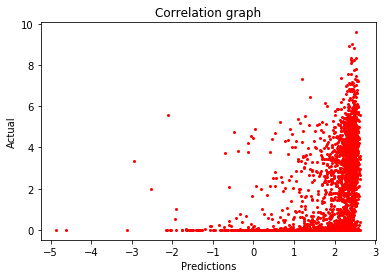

In [20]:
linreg = LinearRegression()
linreg.fit(x_train, np.arcsinh(y_train_regression_labels))
reweighted_preds, _ = evaluate(linreg, x_valid, y_valid_regression_labels)

Spearman R SpearmanrResult(correlation=0.5398310627482766, pvalue=0.0)
Pearson R (0.3846868658893629, 0.0)
Model Performance
MSError: 3.6006 


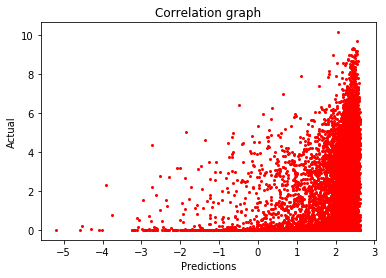

In [21]:
reweighted_preds, _ = evaluate(linreg, x_train, y_train_regression_labels)

/users/kmualim/.conda/envs/jpt/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Spearman R SpearmanrResult(correlation=0.8701123892937461, pvalue=0.0)
Pearson R (0.8990287408777821, 0.0)
Model Performance
MSError: 0.8458 


(0.8457604237686227,
 <module 'matplotlib.pyplot' from '/users/kmualim/.conda/envs/jpt/lib/python3.5/site-packages/matplotlib/pyplot.py'>)

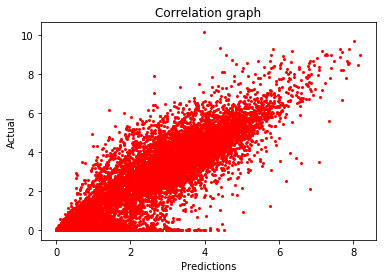

In [22]:
random_forest = RandomForestRegressor()
random_forest.fit(x_train, np.arcsinh(y_train_regression_labels))
evaluate(random_forest, x_train, y_train_regression_labels)

Spearman R SpearmanrResult(correlation=0.35311849907710896, pvalue=6.061487047734765e-90)
Pearson R (0.3368349934485674, 1.6357030272639645e-81)
Model Performance
MSError: 4.6461 


(4.646121033746861,
 <module 'matplotlib.pyplot' from '/users/kmualim/.conda/envs/jpt/lib/python3.5/site-packages/matplotlib/pyplot.py'>)

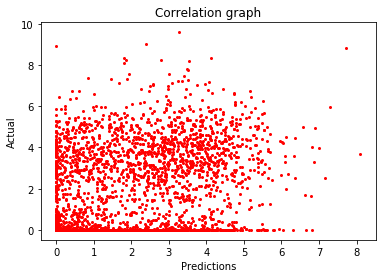

In [23]:
evaluate(random_forest, x_valid, y_valid_regression_labels)

In [7]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {#'n_estimators': 100,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor(n_estimators=32)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 20)
# Fit the random search model
rf_random.fit(x_train, np.arcsinh(y_train_regression_labels))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=20)]: Done 122 tasks      | elapsed:    9.7s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:   16.8s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=32, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=20,
          param_distributions={'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'max_features': ['auto', 'sqrt'], 'min_samples_split': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

Train Spearman R: SpearmanrResult(correlation=0.6080676273212379, pvalue=0.0)
Train Pearson R: (0.6048938339537381, 0.0)
Valid Spearman R: SpearmanrResult(correlation=0.5150967756644846, pvalue=1.5952138176368985e-201)
Valid Pearson R: (0.5115430484029825, 2.553025898490145e-198)
Model Performance
MSError: 3.0964 


array([2.47676315, 0.72911522, 0.51960271, ..., 2.25765752, 0.53316502,
       3.55914309])

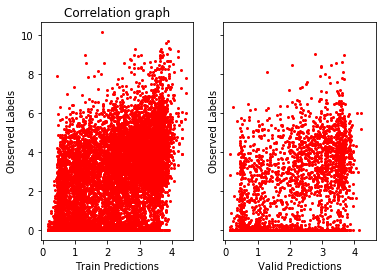

In [10]:
!mkdir ABC.weighted_nonzerodeepsea_predicted_H3K27ac
evaluate(rf_random, x_train, y_train_regression_labels, x_valid, y_valid_regression_labels, 'ABC.weighted_nonzerodeepsea_predicted_H3K27ac', 'ABC.weighted_nonzerodeepsea_predicted_H3K27ac')

In [12]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10}

reference correlation: https://genomebiology.biomedcentral.com/track/pdf/10.1186/gb-2012-13-9-r53

### using features that span across more histone marks 
- Looked at using K562 specific features that were tasks in the deepsea prediction model 

In [ ]:
import numpy as np
import pandas as pd
deepsea_predictions = np.load("/mnt/lab_data2/kmualim/enh-gene-linking/datasets/embeddings/new_version/constant_promoter_weights/constantPromoter_weightedEnhancer_Deepsea.npz")['arr_0']
constant_promoters_abc = pd.read_csv("/mnt/lab_data2/kmualim/enh-gene-linking/datasets/embeddings/new_version/constant_promoter_weights/constantweightedpromoters_abc.csv", sep="\t", header=None)
scores = constant_promoters_abc.iloc[:,4]
genes = constant_promoters_abc.iloc[:,3]

In [32]:
items = np.arange(1919, 1932)
x = np.append([62], items)
deepsea_select_predictions = [i[x] for i in deepsea_predictions]

In [35]:
embeddings_scores = [i*j for i,j in zip(scores, deepsea_select_predictions)]
gene_dictionary = {}
for i in genes.drop_duplicates():
    print("Gene: ", i)
    indices = genes.loc[genes==i].index.astype(int)
    total_scores = [embeddings_scores[i] for i in indices]
    gene_dictionary[i] = np.sum(total_scores, axis=0)
    
outdir = "/mnt/lab_data2/kmualim/enh-gene-linking/datasets/embeddings/new_version/constant_promoter_weights"
with open(os.path.join(outdir,'ConstantPromoterEnahncer_Deepsea_14HistoneMarksDNase_K562.p'), 'wb') as fp:
    pickle.dump(gene_dictionary, fp)

Gene:  DDX11L1
Gene:  WASH7P
Gene:  FAM138A
Gene:  FAM138F
Gene:  OR4F5
Gene:  LOC729737
Gene:  LOC101928626
Gene:  LOC100288069
Gene:  FAM87B
Gene:  LINC00115
Gene:  LINC01128
Gene:  FAM41C
Gene:  LOC100130417
Gene:  SAMD11
Gene:  NOC2L
Gene:  KLHL17
Gene:  PLEKHN1
Gene:  PERM1
Gene:  HES4
Gene:  ISG15
Gene:  AGRN
Gene:  RNF223
Gene:  C1orf159
Gene:  LINC01342
Gene:  TTLL10
Gene:  TNFRSF18
Gene:  TNFRSF4
Gene:  SDF4
Gene:  B3GALT6
Gene:  C1QTNF12
Gene:  UBE2J2
Gene:  SCNN1D
Gene:  ACAP3
Gene:  PUSL1
Gene:  INTS11
Gene:  CPTP
Gene:  TAS1R3
Gene:  DVL1
Gene:  MXRA8
Gene:  AURKAIP1
Gene:  CCNL2
Gene:  LOC148413
Gene:  MRPL20
Gene:  ANKRD65
Gene:  TMEM88B
Gene:  LINC01770
Gene:  VWA1
Gene:  ATAD3C
Gene:  ATAD3B
Gene:  ATAD3A
Gene:  TMEM240
Gene:  SSU72
Gene:  FNDC10
Gene:  MIB2
Gene:  MMP23B
Gene:  SLC35E2B
Gene:  CDK11B
Gene:  CDK11A
Gene:  SLC35E2
Gene:  NADK
Gene:  GNB1
Gene:  CALML6
Gene:  TMEM52
Gene:  CFAP74
Gene:  GABRD
Gene:  LOC105378591
Gene:  PRKCZ
Gene:  FAAP20
Gene:  SKI
Gene

Gene:  GNL2
Gene:  RSPO1
Gene:  C1orf109
Gene:  CDCA8
Gene:  EPHA10
Gene:  MANEAL
Gene:  C1orf122
Gene:  YRDC
Gene:  MTF1
Gene:  INPP5B
Gene:  SF3A3
Gene:  FHL3
Gene:  UTP11
Gene:  POU3F1
Gene:  LINC01343
Gene:  RRAGC
Gene:  MYCBP
Gene:  LOC105378663
Gene:  GJA9
Gene:  GJA9-MYCBP
Gene:  RHBDL2
Gene:  AKIRIN1
Gene:  NDUFS5
Gene:  MACF1
Gene:  KIAA0754
Gene:  BMP8A
Gene:  OXCT2P1
Gene:  PPIEL
Gene:  LOC101929516
Gene:  PABPC4
Gene:  HEYL
Gene:  NT5C1A
Gene:  HPCAL4
Gene:  PPIE
Gene:  OXCT2
Gene:  BMP8B
Gene:  LOC101929536
Gene:  TRIT1
Gene:  MYCL
Gene:  MFSD2A
Gene:  CAP1
Gene:  PPT1
Gene:  RLF
Gene:  TMCO2
Gene:  ZMPSTE24
Gene:  COL9A2
Gene:  SMAP2
Gene:  ZFP69B
Gene:  ZFP69
Gene:  EXO5
Gene:  ZNF684
Gene:  RIMS3
Gene:  NFYC
Gene:  NFYC-AS1
Gene:  KCNQ4
Gene:  CITED4
Gene:  CTPS1
Gene:  SLFNL1-AS1
Gene:  SLFNL1
Gene:  SCMH1
Gene:  FOXO6
Gene:  LOC101929901
Gene:  EDN2
Gene:  HIVEP3
Gene:  GUCA2B
Gene:  GUCA2A
Gene:  FOXJ3
Gene:  RIMKLA
Gene:  ZMYND12
Gene:  PPCS
Gene:  CCDC30
Gene:  PPI

Gene:  KCNC4
Gene:  LOC440600
Gene:  RBM15
Gene:  SLC16A4
Gene:  LAMTOR5-AS1
Gene:  LAMTOR5
Gene:  PROK1
Gene:  CYMP
Gene:  CYMP-AS1
Gene:  KCNA10
Gene:  KCNA2
Gene:  KCNA3
Gene:  CD53
Gene:  LRIF1
Gene:  CEPT1
Gene:  DRAM2
Gene:  DENND2D
Gene:  CHI3L2
Gene:  CHIAP2
Gene:  CHIA
Gene:  PIFO
Gene:  PGCP1
Gene:  OVGP1
Gene:  ATP5F1
Gene:  WDR77
Gene:  C1orf162
Gene:  ADORA3
Gene:  TMIGD3
Gene:  LINC01160
Gene:  RAP1A
Gene:  FAM212B
Gene:  FAM212B-AS1
Gene:  LOC101928718
Gene:  DDX20
Gene:  KCND3-IT1
Gene:  KCND3-AS1
Gene:  KCND3
Gene:  LINC01750
Gene:  CTTNBP2NL
Gene:  WNT2B
Gene:  ST7L
Gene:  CAPZA1
Gene:  MOV10
Gene:  RHOC
Gene:  PPM1J
Gene:  FAM19A3
Gene:  LINC01356
Gene:  AKR7A2P1
Gene:  SLC16A1
Gene:  SLC16A1-AS1
Gene:  LOC100996251
Gene:  LRIG2
Gene:  LOC643441
Gene:  MAGI3
Gene:  PHTF1
Gene:  RSBN1
Gene:  AP4B1-AS1
Gene:  PTPN22
Gene:  BCL2L15
Gene:  AP4B1
Gene:  DCLRE1B
Gene:  HIPK1-AS1
Gene:  HIPK1
Gene:  OLFML3
Gene:  SYT6
Gene:  TRIM33
Gene:  BCAS2
Gene:  DENND2C
Gene:  AMPD1
G

Gene:  RGS4
Gene:  LOC101928404
Gene:  RGS5
Gene:  NUF2
Gene:  LOC100422212
Gene:  PBX1
Gene:  LOC100505795
Gene:  LMX1A
Gene:  RXRG
Gene:  LRRC52
Gene:  LOC400794
Gene:  MGST3
Gene:  ALDH9A1
Gene:  LOC440700
Gene:  TMCO1
Gene:  LOC100147773
Gene:  UCK2
Gene:  FAM78B
Gene:  FMO9P
Gene:  POGK
Gene:  TADA1
Gene:  ILDR2
Gene:  MAEL
Gene:  GPA33
Gene:  DUSP27
Gene:  LINC01363
Gene:  POU2F1
Gene:  CD247
Gene:  CREG1
Gene:  RCSD1
Gene:  MPZL1
Gene:  ADCY10
Gene:  DCAF6
Gene:  MPC2
Gene:  GPR161
Gene:  TIPRL
Gene:  SFT2D2
Gene:  ANKRD36BP1
Gene:  TBX19
Gene:  LOC100505918
Gene:  LOC101928565
Gene:  XCL2
Gene:  XCL1
Gene:  DPT
Gene:  LINC00626
Gene:  LINC00970
Gene:  LOC101928596
Gene:  ATP1B1
Gene:  BLZF1
Gene:  NME7
Gene:  CCDC181
Gene:  SLC19A2
Gene:  F5
Gene:  SELP
Gene:  SELL
Gene:  SELE
Gene:  METTL18
Gene:  C1orf112
Gene:  SCYL3
Gene:  KIFAP3
Gene:  METTL11B
Gene:  LINC01142
Gene:  GORAB
Gene:  LOC101928650
Gene:  PRRX1
Gene:  MROH9
Gene:  FMO3
Gene:  FMO6P
Gene:  FMO2
Gene:  FMO1
Gene:

Gene:  RBM34
Gene:  ARID4B
Gene:  GGPS1
Gene:  TBCE
Gene:  B3GALNT2
Gene:  MIR5096
Gene:  GNG4
Gene:  LYST
Gene:  NID1
Gene:  GPR137B
Gene:  ERO1B
Gene:  EDARADD
Gene:  LGALS8
Gene:  LGALS8-AS1
Gene:  HEATR1
Gene:  ACTN2
Gene:  MTR
Gene:  MT1HL1
Gene:  RYR2
Gene:  LOC100130331
Gene:  ZP4
Gene:  LINC01139
Gene:  CHRM3
Gene:  CHRM3-AS2
Gene:  CHRM3-AS1
Gene:  RPS7P5
Gene:  FMN2
Gene:  MIR1273E
Gene:  GREM2
Gene:  RGS7
Gene:  FH
Gene:  KMO
Gene:  CHML
Gene:  OPN3
Gene:  WDR64
Gene:  EXO1
Gene:  BECN2
Gene:  MAP1LC3C
Gene:  PLD5
Gene:  LINC01347
Gene:  CEP170
Gene:  SDCCAG8
Gene:  AKT3
Gene:  LOC339529
Gene:  ZBTB18
Gene:  C1orf100
Gene:  ADSS
Gene:  CATSPERE
Gene:  DESI2
Gene:  COX20
Gene:  HNRNPU
Gene:  EFCAB2
Gene:  LOC101928068
Gene:  KIF26B
Gene:  SMYD3
Gene:  LINC01743
Gene:  TFB2M
Gene:  CNST
Gene:  SCCPDH
Gene:  LINC01341
Gene:  AHCTF1
Gene:  ZNF695
Gene:  ZNF670-ZNF695
Gene:  ZNF670
Gene:  ZNF669
Gene:  C1orf229
Gene:  ZNF124
Gene:  VN1R5
Gene:  ZNF496
Gene:  NLRP3
Gene:  OR2B11
G

Gene:  NFU1
Gene:  AAK1
Gene:  ANXA4
Gene:  GMCL1
Gene:  SNRNP27
Gene:  MXD1
Gene:  ASPRV1
Gene:  PCBP1-AS1
Gene:  PCBP1
Gene:  LINC01816
Gene:  C2orf42
Gene:  TIA1
Gene:  PCYOX1
Gene:  SNRPG
Gene:  FAM136A
Gene:  TGFA-IT1
Gene:  TGFA
Gene:  ADD2
Gene:  FIGLA
Gene:  CLEC4F
Gene:  CD207
Gene:  LINC01143
Gene:  VAX2
Gene:  ATP6V1B1
Gene:  ATP6V1B1-AS1
Gene:  ANKRD53
Gene:  TEX261
Gene:  OR7E91P
Gene:  NAGK
Gene:  MCEE
Gene:  MPHOSPH10
Gene:  PAIP2B
Gene:  ZNF638
Gene:  DYSF
Gene:  CYP26B1
Gene:  EXOC6B
Gene:  SPR
Gene:  EMX1
Gene:  SFXN5
Gene:  RAB11FIP5
Gene:  NOTO
Gene:  SMYD5
Gene:  PRADC1
Gene:  CCT7
Gene:  FBXO41
Gene:  EGR4
Gene:  ALMS1
Gene:  ALMS1-IT1
Gene:  NAT8
Gene:  ALMS1P1
Gene:  NAT8B
Gene:  TPRKB
Gene:  DUSP11
Gene:  C2orf78
Gene:  STAMBP
Gene:  ACTG2
Gene:  DGUOK
Gene:  DGUOK-AS1
Gene:  TET3
Gene:  BOLA3
Gene:  BOLA3-AS1
Gene:  MOB1A
Gene:  MTHFD2
Gene:  SLC4A5
Gene:  DCTN1
Gene:  DCTN1-AS1
Gene:  C2orf81
Gene:  WDR54
Gene:  RTKN
Gene:  INO80B
Gene:  INO80B-WBP1
Gene:  WB

Gene:  LOC101929532
Gene:  GCG
Gene:  FAP
Gene:  IFIH1
Gene:  GCA
Gene:  LOC101929570
Gene:  KCNH7
Gene:  FIGN
Gene:  GRB14
Gene:  LOC101929633
Gene:  COBLL1
Gene:  SLC38A11
Gene:  SCN3A
Gene:  SCN2A
Gene:  CSRNP3
Gene:  GALNT3
Gene:  LOC100506124
Gene:  TTC21B-AS1
Gene:  TTC21B
Gene:  LOC102724058
Gene:  SCN1A
Gene:  LOC101929680
Gene:  SCN9A
Gene:  SCN7A
Gene:  XIRP2
Gene:  XIRP2-AS1
Gene:  B3GALT1
Gene:  LOC105616981
Gene:  STK39
Gene:  CERS6
Gene:  CERS6-AS1
Gene:  NOSTRIN
Gene:  SPC25
Gene:  G6PC2
Gene:  ABCB11
Gene:  DHRS9
Gene:  LRP2
Gene:  BBS5
Gene:  KLHL41
Gene:  FASTKD1
Gene:  PPIG
Gene:  CCDC173
Gene:  PHOSPHO2-KLHL23
Gene:  PHOSPHO2
Gene:  KLHL23
Gene:  SSB
Gene:  METTL5
Gene:  UBR3
Gene:  MYO3B
Gene:  LOC101929753
Gene:  LINC01124
Gene:  SP5
Gene:  ERICH2
Gene:  LOC101926913
Gene:  GAD1
Gene:  GORASP2
Gene:  TLK1
Gene:  METTL8
Gene:  DCAF17
Gene:  CYBRD1
Gene:  DYNC1I2
Gene:  SLC25A12
Gene:  HAT1
Gene:  METAP1D
Gene:  DLX1
Gene:  DLX2
Gene:  DLX2-AS1
Gene:  ITGA6
Gene:  P

Gene:  LINC01238
Gene:  LINC01881
Gene:  LINC01986
Gene:  CHL1
Gene:  CHL1-AS2
Gene:  CHL1-AS1
Gene:  LINC01266
Gene:  CNTN6
Gene:  CNTN4-AS2
Gene:  CNTN4
Gene:  CNTN4-AS1
Gene:  IL5RA
Gene:  TRNT1
Gene:  CRBN
Gene:  LRRN1
Gene:  SETMAR
Gene:  SUMF1
Gene:  ITPR1-AS1
Gene:  ITPR1
Gene:  EGOT
Gene:  BHLHE40
Gene:  BHLHE40-AS1
Gene:  ARL8B
Gene:  EDEM1
Gene:  GRM7-AS3
Gene:  GRM7
Gene:  GRM7-AS2
Gene:  GRM7-AS1
Gene:  LOC101927394
Gene:  LMCD1-AS1
Gene:  LMCD1
Gene:  LINC00312
Gene:  SSUH2
Gene:  CAV3
Gene:  OXTR
Gene:  RAD18
Gene:  SRGAP3-AS2
Gene:  SRGAP3-AS3
Gene:  SRGAP3
Gene:  THUMPD3
Gene:  THUMPD3-AS1
Gene:  SETD5
Gene:  LHFPL4
Gene:  MTMR14
Gene:  CPNE9
Gene:  BRPF1
Gene:  OGG1
Gene:  CAMK1
Gene:  ARPC4
Gene:  ARPC4-TTLL3
Gene:  TADA3
Gene:  TTLL3
Gene:  RPUSD3
Gene:  CIDEC
Gene:  JAGN1
Gene:  IL17RE
Gene:  IL17RC
Gene:  CRELD1
Gene:  PRRT3-AS1
Gene:  PRRT3
Gene:  EMC3-AS1
Gene:  LOC401052
Gene:  EMC3
Gene:  CIDECP
Gene:  FANCD2
Gene:  FANCD2OS
Gene:  BRK1
Gene:  VHL
Gene:  IRAK2


Gene:  LOC105377146
Gene:  FAM19A4
Gene:  EOGT
Gene:  TMF1
Gene:  UBA3
Gene:  ARL6IP5
Gene:  LMOD3
Gene:  FRMD4B
Gene:  MITF
Gene:  SAMMSON
Gene:  FOXP1-AS1
Gene:  FOXP1
Gene:  EIF4E3
Gene:  GPR27
Gene:  PROK2
Gene:  LINC00877
Gene:  LINC00870
Gene:  RYBP
Gene:  LOC105377162
Gene:  SHQ1
Gene:  GXYLT2
Gene:  PPP4R2
Gene:  EBLN2
Gene:  LOC101927296
Gene:  PDZRN3-AS1
Gene:  PDZRN3
Gene:  CNTN3
Gene:  FAM86DP
Gene:  FRG2EP
Gene:  FRG2C
Gene:  LINC00960
Gene:  ZNF717
Gene:  ROBO2
Gene:  ROBO1
Gene:  LOC101927374
Gene:  LINC02027
Gene:  GBE1
Gene:  LINC00971
Gene:  CADM2
Gene:  CADM2-AS2
Gene:  LINC02070
Gene:  VGLL3
Gene:  LINC00506
Gene:  CHMP2B
Gene:  POU1F1
Gene:  HTR1F
Gene:  CGGBP1
Gene:  ZNF654
Gene:  C3orf38
Gene:  EPHA3
Gene:  PROS1
Gene:  ARL13B
Gene:  STX19
Gene:  NSUN3
Gene:  DHFR2
Gene:  LINC00879
Gene:  MTHFD2P1
Gene:  EPHA6
Gene:  ARL6
Gene:  CRYBG3
Gene:  RIOX2
Gene:  GABRR3
Gene:  OR5AC2
Gene:  OR5H1
Gene:  OR5H14
Gene:  OR5H15
Gene:  OR5H6
Gene:  OR5H2
Gene:  OR5K4
Gene:  O

Gene:  SEC62
Gene:  GPR160
Gene:  PHC3
Gene:  PRKCI
Gene:  SKIL
Gene:  CLDN11
Gene:  LOC101928583
Gene:  SLC7A14
Gene:  RPL22L1
Gene:  EIF5A2
Gene:  SLC2A2
Gene:  TNIK
Gene:  PLD1
Gene:  TMEM212
Gene:  TMEM212-AS1
Gene:  FNDC3B
Gene:  GHSR
Gene:  TNFSF10
Gene:  NCEH1
Gene:  ECT2
Gene:  SPATA16
Gene:  NLGN1
Gene:  NLGN1-AS1
Gene:  NAALADL2
Gene:  NAALADL2-AS3
Gene:  NAALADL2-AS2
Gene:  NAALADL2-AS1
Gene:  LINC01208
Gene:  LINC01209
Gene:  TBL1XR1
Gene:  LINC00501
Gene:  LINC00578
Gene:  LINC02015
Gene:  LINC01014
Gene:  KCNMB2
Gene:  KCNMB2-AS1
Gene:  ZMAT3
Gene:  LOC101928739
Gene:  PIK3CA
Gene:  KCNMB3
Gene:  ZNF639
Gene:  MFN1
Gene:  GNB4
Gene:  ACTL6A
Gene:  MRPL47
Gene:  NDUFB5
Gene:  USP13
Gene:  PEX5L-AS2
Gene:  PEX5L
Gene:  LINC02053
Gene:  TTC14
Gene:  CCDC39
Gene:  LOC101928882
Gene:  FXR1
Gene:  DNAJC19
Gene:  LOC102724604
Gene:  SOX2-OT
Gene:  SOX2
Gene:  LINC01206
Gene:  LINC01994
Gene:  LINC01995
Gene:  ATP11B
Gene:  DCUN1D1
Gene:  MCCC1
Gene:  LAMP3
Gene:  B3GNT5
Gene:  M

Gene:  HOPX
Gene:  SPINK2
Gene:  REST
Gene:  NOA1
Gene:  POLR2B
Gene:  IGFBP7-AS1
Gene:  IGFBP7
Gene:  LOC101928851
Gene:  LOC105377671
Gene:  LOC105377245
Gene:  LOC105377247
Gene:  ADGRL3
Gene:  ADGRL3-AS1
Gene:  TECRL
Gene:  LINC02232
Gene:  EPHA5-AS1
Gene:  EPHA5
Gene:  LOC101927237
Gene:  CENPC
Gene:  STAP1
Gene:  UBA6
Gene:  UBA6-AS1
Gene:  GNRHR
Gene:  TMPRSS11D
Gene:  TMPRSS11A
Gene:  TMPRSS11GP
Gene:  LOC550113
Gene:  SYT14P1
Gene:  TMPRSS11F
Gene:  FTLP10
Gene:  TMPRSS11BNL
Gene:  TMPRSS11B
Gene:  YTHDC1
Gene:  TMPRSS11E
Gene:  UGT2B17
Gene:  UGT2B15
Gene:  UGT2A3
Gene:  UGT2B10
Gene:  UGT2B7
Gene:  LOC105377267
Gene:  UGT2B11
Gene:  UGT2B28
Gene:  UGT2B4
Gene:  UGT2A2
Gene:  UGT2A1
Gene:  SULT1B1
Gene:  SULT1E1
Gene:  CSN1S1
Gene:  CSN2
Gene:  STATH
Gene:  HTN3
Gene:  HTN1
Gene:  CSN1S2AP
Gene:  CSN1S2BP
Gene:  PRR27
Gene:  ODAM
Gene:  FDCSP
Gene:  CSN3
Gene:  CABS1
Gene:  SMR3A
Gene:  SMR3B
Gene:  OPRPN
Gene:  MUC7
Gene:  AMTN
Gene:  AMBN
Gene:  ENAM
Gene:  JCHAIN
Gene:  UT

Gene:  TENM3
Gene:  DCTD
Gene:  FAM92A1P2
Gene:  WWC2-AS2
Gene:  WWC2
Gene:  WWC2-AS1
Gene:  CLDN22
Gene:  CLDN24
Gene:  CDKN2AIP
Gene:  LOC389247
Gene:  ING2
Gene:  RWDD4
Gene:  TRAPPC11
Gene:  STOX2
Gene:  ENPP6
Gene:  LOC728175
Gene:  LOC102723766
Gene:  IRF2
Gene:  LVCAT8
Gene:  CASP3
Gene:  PRIMPOL
Gene:  CENPU
Gene:  SLED1
Gene:  ACSL1
Gene:  MIR3945HG
Gene:  LINC01093
Gene:  HELT
Gene:  SLC25A4
Gene:  CFAP97
Gene:  SNX25
Gene:  LRP2BP
Gene:  ANKRD37
Gene:  UFSP2
Gene:  C4orf47
Gene:  LOC105377590
Gene:  CCDC110
Gene:  PDLIM3
Gene:  SORBS2
Gene:  TLR3
Gene:  FAM149A
Gene:  FLJ38576
Gene:  CYP4V2
Gene:  KLKB1
Gene:  F11
Gene:  F11-AS1
Gene:  MTNR1A
Gene:  FAT1
Gene:  LOC339975
Gene:  LOC100506272
Gene:  ZFP42
Gene:  TRIML2
Gene:  TRIML1
Gene:  LINC01060
Gene:  LINC01262
Gene:  LOC105379514
Gene:  LINC01596
Gene:  FRG1
Gene:  FRG2
Gene:  DBET
Gene:  PLEKHG4B
Gene:  LRRC14B
Gene:  CCDC127
Gene:  SDHA
Gene:  HRAT5
Gene:  PDCD6
Gene:  AHRR
Gene:  EXOC3-AS1
Gene:  EXOC3
Gene:  PP7080
G

Gene:  SLCO6A1
Gene:  LINC00492
Gene:  LINC00491
Gene:  PAM
Gene:  GIN1
Gene:  PPIP5K2
Gene:  C5orf30
Gene:  LINC02115
Gene:  NUDT12
Gene:  RAB9BP1
Gene:  LINC01950
Gene:  EFNA5
Gene:  FBXL17
Gene:  LINC01023
Gene:  FER
Gene:  PJA2
Gene:  MAN2A1
Gene:  LINC01848
Gene:  TMEM232
Gene:  SLC25A46
Gene:  TSLP
Gene:  WDR36
Gene:  CAMK4
Gene:  STARD4-AS1
Gene:  STARD4
Gene:  NREP-AS1
Gene:  NREP
Gene:  EPB41L4A-AS1
Gene:  LOC101927023
Gene:  EPB41L4A
Gene:  EPB41L4A-AS2
Gene:  LINC02200
Gene:  LOC102467216
Gene:  APC
Gene:  SRP19
Gene:  REEP5
Gene:  DCP2
Gene:  MCC
Gene:  TSSK1B
Gene:  YTHDC2
Gene:  KCNN2
Gene:  LINC01957
Gene:  LOC101927078
Gene:  TRIM36
Gene:  PGGT1B
Gene:  CCDC112
Gene:  FEM1C
Gene:  LOC101927100
Gene:  TICAM2
Gene:  TMED7-TICAM2
Gene:  TMED7
Gene:  LOC102467217
Gene:  CDO1
Gene:  AP3S1
Gene:  ATG12
Gene:  LVRN
Gene:  ARL14EPL
Gene:  COMMD10
Gene:  LOC101927190
Gene:  SEMA6A-AS1
Gene:  SEMA6A
Gene:  LINC02214
Gene:  LINC00992
Gene:  LINC02147
Gene:  LINC02148
Gene:  LINC02

Gene:  CDHR2
Gene:  GPRIN1
Gene:  SNCB
Gene:  EIF4E1B
Gene:  TSPAN17
Gene:  LINC01574
Gene:  UNC5A
Gene:  HK3
Gene:  UIMC1
Gene:  ZNF346
Gene:  FGFR4
Gene:  NSD1
Gene:  RAB24
Gene:  PRELID1
Gene:  MXD3
Gene:  LMAN2
Gene:  RGS14
Gene:  SLC34A1
Gene:  PFN3
Gene:  F12
Gene:  GRK6
Gene:  PRR7
Gene:  PRR7-AS1
Gene:  DBN1
Gene:  PDLIM7
Gene:  DOK3
Gene:  DDX41
Gene:  FAM193B
Gene:  TMED9
Gene:  B4GALT7
Gene:  LOC202181
Gene:  FAM153A
Gene:  LOC728554
Gene:  PROP1
Gene:  FAM153C
Gene:  N4BP3
Gene:  RMND5B
Gene:  NHP2
Gene:  GMCL1P1
Gene:  HNRNPAB
Gene:  PHYKPL
Gene:  COL23A1
Gene:  CLK4
Gene:  ZNF354A
Gene:  AACSP1
Gene:  ZNF354B
Gene:  ZFP2
Gene:  ZNF454
Gene:  GRM6
Gene:  ZNF879
Gene:  ZNF354C
Gene:  ADAMTS2
Gene:  RUFY1
Gene:  LOC101928445
Gene:  HNRNPH1
Gene:  C5orf60
Gene:  LOC105377763
Gene:  CBY3
Gene:  CANX
Gene:  MAML1
Gene:  LTC4S
Gene:  MGAT4B
Gene:  SQSTM1
Gene:  MRNIP
Gene:  LOC100996419
Gene:  TBC1D9B
Gene:  RNF130
Gene:  RASGEF1C
Gene:  MAPK9
Gene:  GFPT2
Gene:  CNOT6
Gene:  SC

Gene:  B3GALT4
Gene:  WDR46
Gene:  PFDN6
Gene:  RGL2
Gene:  TAPBP
Gene:  ZBTB22
Gene:  DAXX
Gene:  KIFC1
Gene:  PHF1
Gene:  CUTA
Gene:  SYNGAP1
Gene:  ZBTB9
Gene:  BAK1
Gene:  GGNBP1
Gene:  LINC00336
Gene:  ITPR3
Gene:  LOC101929188
Gene:  UQCC2
Gene:  IP6K3
Gene:  LEMD2
Gene:  MLN
Gene:  LINC01016
Gene:  GRM4
Gene:  HMGA1
Gene:  C6orf1
Gene:  NUDT3
Gene:  RPS10-NUDT3
Gene:  RPS10
Gene:  PACSIN1
Gene:  SPDEF
Gene:  C6orf106
Gene:  LOC101929243
Gene:  SNRPC
Gene:  UHRF1BP1
Gene:  TAF11
Gene:  ANKS1A
Gene:  TCP11
Gene:  SCUBE3
Gene:  ZNF76
Gene:  DEF6
Gene:  PPARD
Gene:  FANCE
Gene:  RPL10A
Gene:  TEAD3
Gene:  TULP1
Gene:  FKBP5
Gene:  LOC285847
Gene:  ARMC12
Gene:  CLPSL2
Gene:  CLPSL1
Gene:  CLPS
Gene:  LHFPL5
Gene:  SRPK1
Gene:  SLC26A8
Gene:  MAPK14
Gene:  MAPK13
Gene:  BRPF3
Gene:  PNPLA1
Gene:  C6orf222
Gene:  ETV7
Gene:  KCTD20
Gene:  PXT1
Gene:  STK38
Gene:  SRSF3
Gene:  PANDAR
Gene:  CDKN1A
Gene:  DINO
Gene:  RAB44
Gene:  CPNE5
Gene:  PPIL1
Gene:  C6orf89
Gene:  PI16
Gene:  MTCH

Gene:  TMEM200A
Gene:  SMLR1
Gene:  EPB41L2
Gene:  AKAP7
Gene:  ARG1
Gene:  MED23
Gene:  ENPP3
Gene:  OR2A4
Gene:  CTAGE9
Gene:  ENPP1
Gene:  CTGF
Gene:  LINC01013
Gene:  MOXD1
Gene:  STX7
Gene:  TAAR9
Gene:  TAAR8
Gene:  TAAR6
Gene:  TAAR5
Gene:  TAAR3P
Gene:  TAAR2
Gene:  TAAR1
Gene:  VNN1
Gene:  VNN3
Gene:  VNN2
Gene:  SLC18B1
Gene:  RPS12
Gene:  LINC00326
Gene:  EYA4
Gene:  LINC01312
Gene:  TARID
Gene:  TCF21
Gene:  TBPL1
Gene:  SLC2A12
Gene:  HMGA1P7
Gene:  SGK1
Gene:  LINC01010
Gene:  LOC101928231
Gene:  LOC101928304
Gene:  ALDH8A1
Gene:  HBS1L
Gene:  MYB
Gene:  AHI1
Gene:  LINC00271
Gene:  PDE7B
Gene:  MTFR2
Gene:  BCLAF1
Gene:  MAP7
Gene:  LOC101928461
Gene:  LOC101928429
Gene:  MAP3K5
Gene:  PEX7
Gene:  SLC35D3
Gene:  NHEG1
Gene:  IL20RA
Gene:  IL22RA2
Gene:  IFNGR1
Gene:  OLIG3
Gene:  LOC102723649
Gene:  LOC100507406
Gene:  TNFAIP3
Gene:  LOC100130476
Gene:  PERP
Gene:  ARFGEF3
Gene:  PBOV1
Gene:  HEBP2
Gene:  NHSL1
Gene:  FLJ46906
Gene:  CCDC28A
Gene:  GVQW2
Gene:  ECT2L
Gen

Gene:  AMPH
Gene:  FAM183BP
Gene:  VPS41
Gene:  POU6F2
Gene:  POU6F2-AS2
Gene:  POU6F2-AS1
Gene:  YAE1D1
Gene:  RALA
Gene:  LINC00265
Gene:  CDK13
Gene:  MPLKIP
Gene:  SUGCT
Gene:  LINC01450
Gene:  LINC01449
Gene:  INHBA-AS1
Gene:  INHBA
Gene:  GLI3
Gene:  LINC01448
Gene:  C7orf25
Gene:  PSMA2
Gene:  MRPL32
Gene:  HECW1
Gene:  HECW1-IT1
Gene:  LOC100506895
Gene:  STK17A
Gene:  COA1
Gene:  BLVRA
Gene:  MRPS24
Gene:  URGCP-MRPS24
Gene:  URGCP
Gene:  UBE2D4
Gene:  SPDYE1
Gene:  POLR2J4
Gene:  LINC00957
Gene:  RASA4CP
Gene:  DBNL
Gene:  PGAM2
Gene:  POLM
Gene:  AEBP1
Gene:  POLD2
Gene:  MYL7
Gene:  GCK
Gene:  YKT6
Gene:  CAMK2B
Gene:  NUDCD3
Gene:  NPC1L1
Gene:  DDX56
Gene:  TMED4
Gene:  OGDH
Gene:  ZMIZ2
Gene:  PPIA
Gene:  H2AFV
Gene:  PURB
Gene:  MYO1G
Gene:  SNHG15
Gene:  CCM2
Gene:  NACAD
Gene:  TBRG4
Gene:  RAMP3
Gene:  ADCY1
Gene:  SEPT7P2
Gene:  IGFBP1
Gene:  IGFBP3
Gene:  LOC730338
Gene:  TNS3
Gene:  LINC01447
Gene:  C7orf65
Gene:  LINC00525
Gene:  C7orf69
Gene:  PKD1L1
Gene:  HUS1

Gene:  FEZF1-AS1
Gene:  FEZF1
Gene:  RNF133
Gene:  RNF148
Gene:  CADPS2
Gene:  TAS2R16
Gene:  SLC13A1
Gene:  IQUB
Gene:  NDUFA5
Gene:  ASB15
Gene:  LOC102724555
Gene:  LMOD2
Gene:  WASL
Gene:  HYALP1
Gene:  HYAL4
Gene:  SPAM1
Gene:  LOC105375483
Gene:  TMEM229A
Gene:  LOC101928211
Gene:  GPR37
Gene:  C7orf77
Gene:  POT1-AS1
Gene:  POT1
Gene:  LOC101928283
Gene:  LOC101928254
Gene:  LOC101928333
Gene:  GRM8
Gene:  ZNF800
Gene:  LOC100506682
Gene:  GCC1
Gene:  ARF5
Gene:  FSCN3
Gene:  PAX4
Gene:  SND1
Gene:  SND1-IT1
Gene:  LRRC4
Gene:  LEP
Gene:  MGC27345
Gene:  RBM28
Gene:  PRRT4
Gene:  IMPDH1
Gene:  HILPDA
Gene:  METTL2B
Gene:  LINC01000
Gene:  FAM71F2
Gene:  FAM71F1
Gene:  CALU
Gene:  OPN1SW
Gene:  CCDC136
Gene:  FLNC
Gene:  ATP6V1F
Gene:  LOC100130705
Gene:  KCP
Gene:  IRF5
Gene:  TNPO3
Gene:  TPI1P2
Gene:  LOC407835
Gene:  TSPAN33
Gene:  SMO
Gene:  AHCYL2
Gene:  STRIP2
Gene:  SMKR1
Gene:  NRF1
Gene:  UBE2H
Gene:  ZC3HC1
Gene:  KLHDC10
Gene:  TMEM209
Gene:  SSMEM1
Gene:  CPA2
Gene: 

Gene:  KIF13B
Gene:  DUSP4
Gene:  LINC00589
Gene:  LINC02099
Gene:  LOC101929470
Gene:  LINC02209
Gene:  SARAF
Gene:  LEPROTL1
Gene:  MBOAT4
Gene:  DCTN6
Gene:  RBPMS
Gene:  RBPMS-AS1
Gene:  SMIM18
Gene:  GTF2E2
Gene:  GSR
Gene:  UBXN8
Gene:  PPP2CB
Gene:  TEX15
Gene:  PURG
Gene:  WRN
Gene:  NRG1-IT1
Gene:  NRG1-IT3
Gene:  NRG1
Gene:  FUT10
Gene:  MAK16
Gene:  TTI2
Gene:  RNF122
Gene:  DUSP26
Gene:  LINC01288
Gene:  UNC5D
Gene:  LOC101929550
Gene:  KCNU1
Gene:  LINC01605
Gene:  ZNF703
Gene:  LOC101929622
Gene:  ERLIN2
Gene:  LOC102723701
Gene:  LOC728024
Gene:  PLPBP
Gene:  ADGRA2
Gene:  BRF2
Gene:  RAB11FIP1
Gene:  GOT1L1
Gene:  ADRB3
Gene:  EIF4EBP1
Gene:  ASH2L
Gene:  STAR
Gene:  BAG4
Gene:  LSM1
Gene:  DDHD2
Gene:  PLPP5
Gene:  NSD3
Gene:  LETM2
Gene:  FGFR1
Gene:  C8orf86
Gene:  TACC1
Gene:  PLEKHA2
Gene:  HTRA4
Gene:  TM2D2
Gene:  ADAM9
Gene:  ADAM32
Gene:  ADAM5
Gene:  ADAM3A
Gene:  LOC100130964
Gene:  ADAM18
Gene:  ADAM2
Gene:  IDO1
Gene:  IDO2
Gene:  C8orf4
Gene:  ZMAT4
Gene: 

Gene:  GPIHBP1
Gene:  ZFP41
Gene:  GLI4
Gene:  MINCR
Gene:  ZNF696
Gene:  TOP1MT
Gene:  RHPN1-AS1
Gene:  RHPN1
Gene:  MAFA-AS1
Gene:  MAFA
Gene:  ZC3H3
Gene:  GSDMD
Gene:  MROH6
Gene:  NAPRT
Gene:  EEF1D
Gene:  TIGD5
Gene:  PYCRL
Gene:  TSTA3
Gene:  ZNF623
Gene:  ZNF707
Gene:  BREA2
Gene:  LOC101928160
Gene:  CCDC166
Gene:  MAPK15
Gene:  FAM83H
Gene:  FAM83H-AS1
Gene:  LOC105375800
Gene:  SCRIB
Gene:  PUF60
Gene:  NRBP2
Gene:  EPPK1
Gene:  PLEC
Gene:  PARP10
Gene:  GRINA
Gene:  SPATC1
Gene:  OPLAH
Gene:  EXOSC4
Gene:  GPAA1
Gene:  CYC1
Gene:  SHARPIN
Gene:  MAF1
Gene:  WDR97
Gene:  HGH1
Gene:  MROH1
Gene:  SCX
Gene:  BOP1
Gene:  HSF1
Gene:  DGAT1
Gene:  SCRT1
Gene:  TMEM249
Gene:  FBXL6
Gene:  SLC52A2
Gene:  LOC101928902
Gene:  ADCK5
Gene:  CPSF1
Gene:  SLC39A4
Gene:  VPS28
Gene:  TONSL-AS1
Gene:  TONSL
Gene:  CYHR1
Gene:  KIFC2
Gene:  FOXH1
Gene:  PPP1R16A
Gene:  GPT
Gene:  MFSD3
Gene:  RECQL4
Gene:  LRRC14
Gene:  LRRC24
Gene:  C8orf82
Gene:  ARHGAP39
Gene:  ZNF251
Gene:  ZNF34
Gene: 

Gene:  ANKRD18CP
Gene:  CCDC180
Gene:  LOC286359
Gene:  TDRD7
Gene:  TMOD1
Gene:  NCBP1
Gene:  TSTD2
Gene:  XPA
Gene:  FOXE1
Gene:  TRMO
Gene:  HEMGN
Gene:  ANP32B
Gene:  NANS
Gene:  TRIM14
Gene:  CORO2A
Gene:  TBC1D2
Gene:  GABBR2
Gene:  ANKS6
Gene:  GALNT12
Gene:  COL15A1
Gene:  TGFBR1
Gene:  ALG2
Gene:  SEC61B
Gene:  NAMA
Gene:  LOC101928438
Gene:  NR4A3
Gene:  STX17-AS1
Gene:  STX17
Gene:  ERP44
Gene:  INVS
Gene:  TEX10
Gene:  MSANTD3
Gene:  MSANTD3-TMEFF1
Gene:  TMEFF1
Gene:  MURC
Gene:  PLPPR1
Gene:  BAAT
Gene:  MRPL50
Gene:  ZNF189
Gene:  ALDOB
Gene:  TMEM246-AS1
Gene:  TMEM246
Gene:  RNF20
Gene:  PPP3R2
Gene:  GRIN3A
Gene:  LINC00587
Gene:  CYLC2
Gene:  LINC01492
Gene:  LOC101928523
Gene:  SMC2-AS1
Gene:  SMC2
Gene:  LOC105376194
Gene:  OR13F1
Gene:  OR13C4
Gene:  OR13C3
Gene:  OR13C8
Gene:  OR13C5
Gene:  OR13C2
Gene:  OR13C9
Gene:  OR13D1
Gene:  NIPSNAP3A
Gene:  NIPSNAP3B
Gene:  ABCA1
Gene:  SLC44A1
Gene:  FSD1L
Gene:  FKTN
Gene:  TAL2
Gene:  TMEM38B
Gene:  LINC01505
Gene:  ZN

Gene:  OPTN
Gene:  MCM10
Gene:  UCMA
Gene:  PHYH
Gene:  SEPHS1
Gene:  BEND7
Gene:  PRPF18
Gene:  LOC101928453
Gene:  FRMD4A
Gene:  FAM107B
Gene:  CDNF
Gene:  HSPA14
Gene:  SUV39H2
Gene:  DCLRE1C
Gene:  MEIG1
Gene:  LOC105376430
Gene:  DCLRE1CP1
Gene:  OLAH
Gene:  ACBD7
Gene:  ACBD7-DCLRE1CP1
Gene:  RPP38
Gene:  C10orf111
Gene:  PPIAP30
Gene:  NMT2
Gene:  FAM171A1
Gene:  ITGA8
Gene:  MINDY3
Gene:  PTER
Gene:  C1QL3
Gene:  RSU1
Gene:  CUBN
Gene:  TRDMT1
Gene:  VIM
Gene:  VIM-AS1
Gene:  ST8SIA6-AS1
Gene:  ST8SIA6
Gene:  HACD1
Gene:  STAM-AS1
Gene:  STAM
Gene:  MRC1
Gene:  TMEM236
Gene:  SLC39A12
Gene:  SLC39A12-AS1
Gene:  CACNB2
Gene:  NSUN6
Gene:  ARL5B
Gene:  MALRD1
Gene:  LOC101928834
Gene:  PLXDC2
Gene:  C10orf113
Gene:  NEBL
Gene:  NEBL-AS1
Gene:  CASC10
Gene:  SKIDA1
Gene:  MLLT10
Gene:  DNAJC1
Gene:  EBLN1
Gene:  LOC100130992
Gene:  COMMD3
Gene:  COMMD3-BMI1
Gene:  BMI1
Gene:  SPAG6
Gene:  LOC100499489
Gene:  PIP4K2A
Gene:  ARMC3
Gene:  MSRB2
Gene:  PTF1A
Gene:  C10orf67
Gene:  OTU

Gene:  CYP2C9
Gene:  CYP2C8
Gene:  ACSM6
Gene:  PDLIM1
Gene:  SORBS1
Gene:  ALDH18A1
Gene:  TCTN3
Gene:  ENTPD1
Gene:  CC2D2B
Gene:  CCNJ
Gene:  ENTPD1-AS1
Gene:  ZNF518A
Gene:  BLNK
Gene:  DNTT
Gene:  OPALIN
Gene:  TLL2
Gene:  TM9SF3
Gene:  PIK3AP1
Gene:  LCOR
Gene:  LOC102723665
Gene:  SLIT1-AS1
Gene:  SLIT1
Gene:  ARHGAP19-SLIT1
Gene:  ARHGAP19
Gene:  FRAT1
Gene:  FRAT2
Gene:  RRP12
Gene:  PGAM1
Gene:  EXOSC1
Gene:  ZDHHC16
Gene:  MMS19
Gene:  UBTD1
Gene:  ANKRD2
Gene:  HOGA1
Gene:  C10orf62
Gene:  MORN4
Gene:  PI4K2A
Gene:  AVPI1
Gene:  MARVELD1
Gene:  ZFYVE27
Gene:  SFRP5
Gene:  LINC00866
Gene:  GOLGA7B
Gene:  CRTAC1
Gene:  R3HCC1L
Gene:  LOXL4
Gene:  PYROXD2
Gene:  LOC101927278
Gene:  HPS1
Gene:  HPSE2
Gene:  CNNM1
Gene:  GOT1
Gene:  LINC01475
Gene:  NKX2-3
Gene:  SLC25A28
Gene:  ENTPD7
Gene:  CUTC
Gene:  COX15
Gene:  ABCC2
Gene:  DNMBP
Gene:  DNMBP-AS1
Gene:  CPN1
Gene:  ERLIN1
Gene:  CHUK
Gene:  CWF19L1
Gene:  BLOC1S2
Gene:  PKD2L1
Gene:  SCD
Gene:  OLMALINC
Gene:  WNT8B
Gene: 

Gene:  RPL27A
Gene:  LOC102724784
Gene:  ST5
Gene:  AKIP1
Gene:  C11orf16
Gene:  ASCL3
Gene:  TMEM9B-AS1
Gene:  TMEM9B
Gene:  NRIP3
Gene:  SCUBE2
Gene:  KRT8P41
Gene:  DENND5A
Gene:  TMEM41B
Gene:  IPO7
Gene:  LOC644656
Gene:  ZNF143
Gene:  WEE1
Gene:  SWAP70
Gene:  SBF2-AS1
Gene:  LOC440028
Gene:  LOC101928008
Gene:  SBF2
Gene:  ADM
Gene:  CAND1.11
Gene:  AMPD3
Gene:  MTRNR2L8
Gene:  RNF141
Gene:  MRVI1-AS1
Gene:  LYVE1
Gene:  MRVI1
Gene:  CTR9
Gene:  EIF4G2
Gene:  LOC101928053
Gene:  ZBED5
Gene:  ZBED5-AS1
Gene:  CSNK2A3
Gene:  GALNT18
Gene:  USP47
Gene:  DKK3
Gene:  LOC105376554
Gene:  MICAL2
Gene:  MICALCL
Gene:  PARVA
Gene:  TEAD1
Gene:  LINC00958
Gene:  RASSF10
Gene:  ARNTL
Gene:  BTBD10
Gene:  PTH
Gene:  FAR1
Gene:  LOC101928132
Gene:  SPON1
Gene:  RRAS2
Gene:  COPB1
Gene:  PSMA1
Gene:  PDE3B
Gene:  CYP2R1
Gene:  CALCA
Gene:  CALCB
Gene:  INSC
Gene:  LOC102724957
Gene:  SOX6
Gene:  C11orf58
Gene:  PLEKHA7
Gene:  OR7E14P
Gene:  RPS13
Gene:  PIK3C2A
Gene:  NUCB2
Gene:  LOC10537657

Gene:  DPF2
Gene:  TIGD3
Gene:  SLC25A45
Gene:  FRMD8
Gene:  NEAT1
Gene:  MALAT1
Gene:  TALAM1
Gene:  SCYL1
Gene:  LTBP3
Gene:  SSSCA1-AS1
Gene:  SSSCA1
Gene:  FAM89B
Gene:  EHBP1L1
Gene:  KCNK7
Gene:  MAP3K11
Gene:  PCNX3
Gene:  SIPA1
Gene:  RELA
Gene:  KAT5
Gene:  RNASEH2C
Gene:  AP5B1
Gene:  OVOL1
Gene:  OVOL1-AS1
Gene:  SNX32
Gene:  CFL1
Gene:  MUS81
Gene:  EFEMP2
Gene:  CTSW
Gene:  FIBP
Gene:  CCDC85B
Gene:  FOSL1
Gene:  C11orf68
Gene:  DRAP1
Gene:  TSGA10IP
Gene:  SART1
Gene:  BANF1
Gene:  EIF1AD
Gene:  CST6
Gene:  CATSPER1
Gene:  GAL3ST3
Gene:  SF3B2
Gene:  PACS1
Gene:  KLC2
Gene:  RAB1B
Gene:  CNIH2
Gene:  YIF1A
Gene:  TMEM151A
Gene:  CD248
Gene:  RIN1
Gene:  BRMS1
Gene:  B4GAT1
Gene:  LOC102724064
Gene:  SLC29A2
Gene:  NPAS4
Gene:  MRPL11
Gene:  PELI3
Gene:  DPP3
Gene:  LOC101928069
Gene:  BBS1
Gene:  ZDHHC24
Gene:  ACTN3
Gene:  CTSF
Gene:  CCDC87
Gene:  CCS
Gene:  RBM14
Gene:  RBM14-RBM4
Gene:  RBM4
Gene:  RBM4B
Gene:  SPTBN2
Gene:  C11orf80
Gene:  RCE1
Gene:  LRFN4
Gene:  PC

Gene:  OR10G4
Gene:  OR10G9
Gene:  OR10G8
Gene:  OR10G7
Gene:  VWA5A
Gene:  OR8G2P
Gene:  OR8G1
Gene:  OR8G5
Gene:  OR8D1
Gene:  OR8D2
Gene:  OR8B2
Gene:  OR8B3
Gene:  OR8B4
Gene:  OR8B8
Gene:  OR8B12
Gene:  OR8A1
Gene:  PANX3
Gene:  TBRG1
Gene:  SPA17
Gene:  SIAE
Gene:  NRGN
Gene:  VSIG2
Gene:  LOC101929340
Gene:  ESAM
Gene:  MSANTD2
Gene:  LOC100507283
Gene:  ROBO3
Gene:  ROBO4
Gene:  HEPN1
Gene:  HEPACAM
Gene:  CCDC15
Gene:  SLC37A2
Gene:  TMEM218
Gene:  PKNOX2-AS1
Gene:  PKNOX2
Gene:  LOC403312
Gene:  FEZ1
Gene:  EI24
Gene:  STT3A-AS1
Gene:  STT3A
Gene:  CHEK1
Gene:  ACRV1
Gene:  PATE1
Gene:  PATE2
Gene:  PATE3
Gene:  PATE4
Gene:  HYLS1
Gene:  PUS3
Gene:  DDX25
Gene:  CDON
Gene:  RPUSD4
Gene:  FAM118B
Gene:  SRPRA
Gene:  FOXRED1
Gene:  TIRAP
Gene:  DCPS
Gene:  GSEC
Gene:  ST3GAL4
Gene:  LOC101929427
Gene:  KIRREL3-AS2
Gene:  KIRREL3
Gene:  KIRREL3-AS3
Gene:  LOC101929473
Gene:  LOC101929497
Gene:  ETS1
Gene:  LOC101929517
Gene:  LOC101929538
Gene:  FLI1
Gene:  SENCR
Gene:  KCNJ1
Ge

Gene:  AQP6
Gene:  RACGAP1
Gene:  ASIC1
Gene:  SMARCD1
Gene:  GPD1
Gene:  COX14
Gene:  CERS5
Gene:  LIMA1
Gene:  FAM186A
Gene:  LARP4
Gene:  DIP2B
Gene:  ATF1
Gene:  TMPRSS12
Gene:  METTL7A
Gene:  HIGD1C
Gene:  SLC11A2
Gene:  LETMD1
Gene:  CSRNP2
Gene:  TFCP2
Gene:  POU6F1
Gene:  DAZAP2
Gene:  SMAGP
Gene:  BIN2
Gene:  CELA1
Gene:  GALNT6
Gene:  SLC4A8
Gene:  SCN8A
Gene:  FIGNL2
Gene:  LOC105369971
Gene:  ANKRD33
Gene:  ACVRL1
Gene:  ACVR1B
Gene:  GRASP
Gene:  NR4A1
Gene:  ATG101
Gene:  OR7E47P
Gene:  KRT80
Gene:  C12orf80
Gene:  LINC00592
Gene:  KRT7
Gene:  KRT86
Gene:  KRT81
Gene:  KRT83
Gene:  KRT85
Gene:  KRT84
Gene:  KRT82
Gene:  KRT75
Gene:  KRT6B
Gene:  KRT6C
Gene:  KRT6A
Gene:  KRT5
Gene:  KRT71
Gene:  KRT74
Gene:  KRT72
Gene:  KRT73-AS1
Gene:  KRT73
Gene:  KRT2
Gene:  KRT1
Gene:  KRT77
Gene:  KRT76
Gene:  KRT3
Gene:  KRT4
Gene:  KRT79
Gene:  KRT78
Gene:  KRT18
Gene:  KRT8
Gene:  EIF4B
Gene:  TNS2
Gene:  LOC283335
Gene:  SPRYD3
Gene:  IGFBP6
Gene:  SOAT2
Gene:  CSAD
Gene:  ZNF74

Gene:  OAS1
Gene:  OAS3
Gene:  OAS2
Gene:  DTX1
Gene:  RASAL1
Gene:  CFAP73
Gene:  DDX54
Gene:  RITA1
Gene:  IQCD
Gene:  TPCN1
Gene:  SLC8B1
Gene:  PLBD2
Gene:  SDS
Gene:  SDSL
Gene:  LHX5-AS1
Gene:  LHX5
Gene:  LINC01234
Gene:  RBM19
Gene:  TBX5-AS1
Gene:  TBX5
Gene:  TBX3
Gene:  MED13L
Gene:  LINC00173
Gene:  MAP1LC3B2
Gene:  C12orf49
Gene:  RNFT2
Gene:  HRK
Gene:  FBXW8
Gene:  LOC100506551
Gene:  TESC
Gene:  TESC-AS1
Gene:  FBXO21
Gene:  NOS1
Gene:  KSR2
Gene:  RFC5
Gene:  WSB2
Gene:  VSIG10
Gene:  PEBP1
Gene:  TAOK3
Gene:  SUDS3
Gene:  LOC105370014
Gene:  LOC105370016
Gene:  SRRM4
Gene:  LOC105370024
Gene:  HSPB8
Gene:  LINC00934
Gene:  CCDC60
Gene:  TMEM233
Gene:  PRKAB1
Gene:  CIT
Gene:  BICDL1
Gene:  RAB35
Gene:  GCN1
Gene:  RPLP0
Gene:  PXN-AS1
Gene:  PXN
Gene:  SIRT4
Gene:  PLA2G1B
Gene:  MSI1
Gene:  COX6A1
Gene:  TRIAP1
Gene:  GATC
Gene:  SRSF9
Gene:  NRAV
Gene:  DYNLL1
Gene:  COQ5
Gene:  RNF10
Gene:  POP5
Gene:  CABP1
Gene:  MLEC
Gene:  UNC119B
Gene:  ACADS
Gene:  SPPL3
Gene

Gene:  LINC01078
Gene:  TBC1D4
Gene:  COMMD6
Gene:  UCHL3
Gene:  LMO7
Gene:  LMO7-AS1
Gene:  LMO7DN
Gene:  LMO7DN-IT1
Gene:  KCTD12
Gene:  BTF3P11
Gene:  ACOD1
Gene:  CLN5
Gene:  FBXL3
Gene:  MYCBP2-AS1
Gene:  MYCBP2
Gene:  SCEL
Gene:  SCEL-AS1
Gene:  LOC100129307
Gene:  SLAIN1
Gene:  EDNRB-AS1
Gene:  EDNRB
Gene:  LINC01069
Gene:  LINC00446
Gene:  RNF219-AS1
Gene:  POU4F1
Gene:  RNF219
Gene:  LINC00331
Gene:  RBM26
Gene:  RBM26-AS1
Gene:  NDFIP2
Gene:  NDFIP2-AS1
Gene:  LINC01068
Gene:  LINC01038
Gene:  LINC00382
Gene:  LINC01080
Gene:  SPRY2
Gene:  LINC00377
Gene:  LINC00564
Gene:  SLITRK1
Gene:  LINC00333
Gene:  LINC00375
Gene:  LINC00351
Gene:  SLITRK6
Gene:  LINC00430
Gene:  MIR4500HG
Gene:  SLITRK5
Gene:  LINC00397
Gene:  LOC105370306
Gene:  LINC00433
Gene:  LINC00560
Gene:  LINC00440
Gene:  LINC01047
Gene:  LINC01040
Gene:  LINC00353
Gene:  LINC00559
Gene:  LINC01049
Gene:  LINC00410
Gene:  LINC00380
Gene:  LINC00379
Gene:  MIR17HG
Gene:  GPC5
Gene:  GPC5-AS2
Gene:  GPC5-AS1
Gene

Gene:  CCDC175
Gene:  RTN1
Gene:  LRRC9
Gene:  PCNX4
Gene:  DHRS7
Gene:  PPM1A
Gene:  C14orf39
Gene:  SIX6
Gene:  SALRNA1
Gene:  SIX1
Gene:  SIX4
Gene:  MNAT1
Gene:  TRMT5
Gene:  SLC38A6
Gene:  TMEM30B
Gene:  PRKCH
Gene:  LOC101927780
Gene:  FLJ22447
Gene:  HIF1A
Gene:  HIF1A-AS1
Gene:  HIF1A-AS2
Gene:  LOC105370526
Gene:  SNAPC1
Gene:  SYT16
Gene:  LINC00643
Gene:  LINC00644
Gene:  KCNH5
Gene:  RHOJ
Gene:  GPHB5
Gene:  PPP2R5E
Gene:  WDR89
Gene:  SGPP1
Gene:  SYNE2
Gene:  ESR2
Gene:  TEX21P
Gene:  MTHFD1
Gene:  AKAP5
Gene:  ZBTB1
Gene:  ZBTB25
Gene:  LOC102723809
Gene:  HSPA2
Gene:  PPP1R36
Gene:  PLEKHG3
Gene:  SPTB
Gene:  CHURC1
Gene:  CHURC1-FNTB
Gene:  GPX2
Gene:  RAB15
Gene:  FNTB
Gene:  LOC100506321
Gene:  MAX
Gene:  LOC100128233
Gene:  FUT8
Gene:  FUT8-AS1
Gene:  LINC00238
Gene:  GPHN
Gene:  FAM71D
Gene:  MPP5
Gene:  ATP6V1D
Gene:  EIF2S1
Gene:  PLEK2
Gene:  TMEM229B
Gene:  PLEKHH1
Gene:  PIGH
Gene:  ARG2
Gene:  VTI1B
Gene:  RDH11
Gene:  RDH12
Gene:  ZFYVE26
Gene:  RAD51B
Gene:

Gene:  PHGR1
Gene:  DISP2
Gene:  KNSTRN
Gene:  IVD
Gene:  BAHD1
Gene:  CHST14
Gene:  MRPL42P5
Gene:  C15orf57
Gene:  RPUSD2
Gene:  KNL1
Gene:  RAD51-AS1
Gene:  RAD51
Gene:  RMDN3
Gene:  GCHFR
Gene:  C15orf62
Gene:  ZFYVE19
Gene:  DNAJC17
Gene:  PPP1R14D
Gene:  SPINT1
Gene:  RHOV
Gene:  VPS18
Gene:  LOC105370943
Gene:  DLL4
Gene:  CHAC1
Gene:  INO80
Gene:  EXD1
Gene:  CHP1
Gene:  OIP5-AS1
Gene:  OIP5
Gene:  NUSAP1
Gene:  NDUFAF1
Gene:  RTF1
Gene:  ITPKA
Gene:  LTK
Gene:  RPAP1
Gene:  TYRO3
Gene:  MGA
Gene:  MAPKBP1
Gene:  JMJD7
Gene:  JMJD7-PLA2G4B
Gene:  PLA2G4B
Gene:  LOC105370792
Gene:  SPTBN5
Gene:  EHD4-AS1
Gene:  EHD4
Gene:  PLA2G4E-AS1
Gene:  PLA2G4E
Gene:  PLA2G4D
Gene:  PLA2G4F
Gene:  VPS39
Gene:  TMEM87A
Gene:  GANC
Gene:  CAPN3
Gene:  ZNF106
Gene:  SNAP23
Gene:  LRRC57
Gene:  HAUS2
Gene:  STARD9
Gene:  CDAN1
Gene:  TTBK2
Gene:  UBR1
Gene:  TMEM62
Gene:  CCNDBP1
Gene:  EPB42
Gene:  TGM5
Gene:  TGM7
Gene:  ADAL
Gene:  LCMT2
Gene:  ZSCAN29
Gene:  TUBGCP4
Gene:  TP53BP1
Gene:  MA

Gene:  LINC01579
Gene:  LINC01580
Gene:  LINC01581
Gene:  MCTP2
Gene:  LOC440311
Gene:  LINC01197
Gene:  LINC00924
Gene:  NR2F2-AS1
Gene:  NR2F2
Gene:  SPATA8-AS1
Gene:  SPATA8
Gene:  LOC101927286
Gene:  LOC101927310
Gene:  LINC00923
Gene:  ARRDC4
Gene:  LINC01582
Gene:  FAM169B
Gene:  IGF1R
Gene:  IRAIN
Gene:  PGPEP1L
Gene:  LUNAR1
Gene:  SYNM
Gene:  TTC23
Gene:  LRRC28
Gene:  HSP90B2P
Gene:  MEF2A
Gene:  LYSMD4
Gene:  DNM1P46
Gene:  LOC400464
Gene:  ADAMTS17
Gene:  SPATA41
Gene:  CERS3-AS1
Gene:  CERS3
Gene:  LOC102723335
Gene:  PRKXP1
Gene:  LINS1
Gene:  ASB7
Gene:  ALDH1A3
Gene:  LRRK1
Gene:  LOC101927751
Gene:  CHSY1
Gene:  SELENOS
Gene:  SNRPA1
Gene:  LOC100507472
Gene:  PCSK6-AS1
Gene:  PCSK6
Gene:  TM2D3
Gene:  TARSL2
Gene:  LOC100128108
Gene:  OR4F6
Gene:  OR4F15
Gene:  OR4F13P
Gene:  OR4F4
Gene:  FAM138E
Gene:  WASH3P
Gene:  DDX11L9
Gene:  DDX11L10
Gene:  WASIR2
Gene:  POLR3K
Gene:  SNRNP25
Gene:  RHBDF1
Gene:  MPG
Gene:  NPRL3
Gene:  HBZ
Gene:  HBM
Gene:  HBA2
Gene:  HBA1
Ge

Gene:  CLUHP3
Gene:  ZNF720
Gene:  VN1R3
Gene:  ZNF267
Gene:  LOC102723753
Gene:  HERC2P4
Gene:  TP53TG3D
Gene:  LOC390705
Gene:  TP53TG3
Gene:  TP53TG3B
Gene:  TP53TG3F
Gene:  SLC6A10P
Gene:  TP53TG3C
Gene:  ENPP7P13
Gene:  LINC00273
Gene:  UBE2MP1
Gene:  LINC01566
Gene:  FRG2DP
Gene:  TP53TG3HP
Gene:  LINC02167
Gene:  ANKRD26P1
Gene:  SHCBP1
Gene:  VPS35
Gene:  ORC6
Gene:  MYLK3
Gene:  C16orf87
Gene:  GPT2
Gene:  DNAJA2
Gene:  NETO2
Gene:  ITFG1-AS1
Gene:  ITFG1
Gene:  PHKB
Gene:  LINC02133
Gene:  LINC02192
Gene:  ABCC12
Gene:  ABCC11
Gene:  LONP2
Gene:  MIR5095
Gene:  SIAH1
Gene:  N4BP1
Gene:  CBLN1
Gene:  C16orf78
Gene:  ADAM3B
Gene:  ZNF423
Gene:  CNEP1R1
Gene:  HEATR3
Gene:  PAPD5
Gene:  ADCY7
Gene:  BRD7
Gene:  NKD1
Gene:  LOC101927272
Gene:  SNX20
Gene:  NOD2
Gene:  CYLD
Gene:  LINC02127
Gene:  SALL1
Gene:  LINC01571
Gene:  C16orf97
Gene:  LINC00919
Gene:  LINC02180
Gene:  CASC22
Gene:  TOX3
Gene:  CASC16
Gene:  LOC105371267
Gene:  CHD9
Gene:  LOC643802
Gene:  LOC102723373
Gene

Gene:  MED11
Gene:  CXCL16
Gene:  ZMYND15
Gene:  TM4SF5
Gene:  VMO1
Gene:  GLTPD2
Gene:  PSMB6
Gene:  PLD2
Gene:  MINK1
Gene:  C17orf107
Gene:  CHRNE
Gene:  GP1BA
Gene:  RNF167
Gene:  SLC25A11
Gene:  PFN1
Gene:  ENO3
Gene:  SPAG7
Gene:  CAMTA2
Gene:  INCA1
Gene:  KIF1C
Gene:  LOC102724009
Gene:  SLC52A1
Gene:  ZFP3
Gene:  LOC101928000
Gene:  ZNF232
Gene:  USP6
Gene:  ZNF594
Gene:  LOC100130950
Gene:  SCIMP
Gene:  RABEP1
Gene:  RPAIN
Gene:  NUP88
Gene:  C1QBP
Gene:  DHX33
Gene:  LOC105371506
Gene:  DERL2
Gene:  MIS12
Gene:  LOC728392
Gene:  NLRP1
Gene:  LOC339166
Gene:  WSCD1
Gene:  AIPL1
Gene:  PIMREG
Gene:  PITPNM3
Gene:  TXNDC17
Gene:  KIAA0753
Gene:  MED31
Gene:  C17orf100
Gene:  ALOX15P1
Gene:  SLC13A5
Gene:  XAF1
Gene:  FBXO39
Gene:  TEKT1
Gene:  ALOX12P2
Gene:  ALOX12
Gene:  ALOX12-AS1
Gene:  RNASEK
Gene:  RNASEK-C17orf49
Gene:  C17orf49
Gene:  MIR497HG
Gene:  BCL6B
Gene:  SLC16A13
Gene:  SLC16A11
Gene:  CLEC10A
Gene:  ASGR2
Gene:  ASGR1
Gene:  ACADVL
Gene:  DLG4
Gene:  DVL2
Gene

Gene:  KRTAP9-8
Gene:  KRTAP9-4
Gene:  KRTAP9-9
Gene:  KRTAP9-6
Gene:  KRTAP9-7
Gene:  KRTAP29-1
Gene:  KRTAP16-1
Gene:  KRTAP17-1
Gene:  KRT33A
Gene:  KRT33B
Gene:  KRT34
Gene:  KRT31
Gene:  LOC100505782
Gene:  KRT37
Gene:  KRT38
Gene:  KRT32
Gene:  KRT35
Gene:  KRT36
Gene:  KRT13
Gene:  KRT15
Gene:  KRT19
Gene:  LINC00974
Gene:  KRT9
Gene:  KRT14
Gene:  KRT16
Gene:  KRT17
Gene:  KRT42P
Gene:  EIF1
Gene:  GAST
Gene:  HAP1
Gene:  JUP
Gene:  P3H4
Gene:  FKBP10
Gene:  NT5C3B
Gene:  KLHL10
Gene:  KLHL11
Gene:  ACLY
Gene:  TTC25
Gene:  CNP
Gene:  DNAJC7
Gene:  NKIRAS2
Gene:  ZNF385C
Gene:  DHX58
Gene:  KAT2A
Gene:  HSPB9
Gene:  RAB5C
Gene:  KCNH4
Gene:  HCRT
Gene:  GHDC
Gene:  STAT5B
Gene:  STAT5A
Gene:  STAT3
Gene:  PTRF
Gene:  ATP6V0A1
Gene:  NAGLU
Gene:  HSD17B1
Gene:  LOC108783654
Gene:  COASY
Gene:  MLX
Gene:  PSMC3IP
Gene:  TUBG1
Gene:  FAM134C
Gene:  TUBG2
Gene:  PLEKHH3
Gene:  CCR10
Gene:  CNTNAP1
Gene:  EZH1
Gene:  RAMP2
Gene:  RAMP2-AS1
Gene:  VPS25
Gene:  WNK4
Gene:  COA3
Gene: 

Gene:  MGAT5B
Gene:  LOC105371899
Gene:  SNHG20
Gene:  SEC14L1
Gene:  SEPT9
Gene:  LOC105371907
Gene:  LOC100507351
Gene:  LINC01987
Gene:  LINC01973
Gene:  TNRC6C
Gene:  TNRC6C-AS1
Gene:  TMC6
Gene:  TMC8
Gene:  C17orf99
Gene:  SYNGR2
Gene:  TK1
Gene:  AFMID
Gene:  BIRC5
Gene:  TMEM235
Gene:  LINC01993
Gene:  SOCS3
Gene:  LOC101928674
Gene:  PGS1
Gene:  DNAH17-AS1
Gene:  DNAH17
Gene:  LINC02081
Gene:  CYTH1
Gene:  USP36
Gene:  CEP295NL
Gene:  TIMP2
Gene:  LGALS3BP
Gene:  CANT1
Gene:  C1QTNF1
Gene:  C1QTNF1-AS1
Gene:  ENGASE
Gene:  RBFOX3
Gene:  LINC02078
Gene:  ENPP7
Gene:  CBX2
Gene:  CBX8
Gene:  CBX4
Gene:  LINC01978
Gene:  LINC01979
Gene:  TBC1D16
Gene:  CCDC40
Gene:  GAA
Gene:  EIF4A3
Gene:  CARD14
Gene:  SGSH
Gene:  SLC26A11
Gene:  RNF213
Gene:  ENDOV
Gene:  LOC100294362
Gene:  NPTX1
Gene:  RPTOR
Gene:  LOC101928855
Gene:  CHMP6
Gene:  BAIAP2-AS1
Gene:  BAIAP2
Gene:  AATK
Gene:  AATK-AS1
Gene:  CEP131
Gene:  LOC105371925
Gene:  TEPSIN
Gene:  NDUFAF8
Gene:  SLC38A10
Gene:  LINC004

Gene:  ABHD17A
Gene:  ADAT3
Gene:  SCAMP4
Gene:  CSNK1G2
Gene:  CSNK1G2-AS1
Gene:  BTBD2
Gene:  MKNK2
Gene:  MOB3A
Gene:  IZUMO4
Gene:  AP3D1
Gene:  DOT1L
Gene:  PLEKHJ1
Gene:  SF3A2
Gene:  AMH
Gene:  JSRP1
Gene:  OAZ1
Gene:  C19orf35
Gene:  LINGO3
Gene:  LSM7
Gene:  SPPL2B
Gene:  TMPRSS9
Gene:  TIMM13
Gene:  LMNB2
Gene:  LINC01775
Gene:  GADD45B
Gene:  GNG7
Gene:  DIRAS1
Gene:  SLC39A3
Gene:  SGTA
Gene:  THOP1
Gene:  ZNF554
Gene:  ZNF555
Gene:  ZNF556
Gene:  ZNF57
Gene:  ZNF77
Gene:  TLE6
Gene:  TLE2
Gene:  AES
Gene:  GNA11
Gene:  GNA15
Gene:  LOC100996351
Gene:  S1PR4
Gene:  NCLN
Gene:  CELF5
Gene:  NFIC
Gene:  SMIM24
Gene:  DOHH
Gene:  FZR1
Gene:  C19orf71
Gene:  MFSD12
Gene:  HMG20B
Gene:  GIPC3
Gene:  TBXA2R
Gene:  CACTIN-AS1
Gene:  CACTIN
Gene:  PIP5K1C
Gene:  TJP3
Gene:  APBA3
Gene:  MRPL54
Gene:  RAX2
Gene:  MATK
Gene:  ZFR2
Gene:  ATCAY
Gene:  NMRK2
Gene:  DAPK3
Gene:  EEF2
Gene:  PIAS4
Gene:  ZBTB7A
Gene:  MAP2K2
Gene:  CREB3L3
Gene:  SIRT6
Gene:  ANKRD24
Gene:  EBI3
Gene:  C

Gene:  UQCRFS1
Gene:  LOC284395
Gene:  VSTM2B
Gene:  POP4
Gene:  PLEKHF1
Gene:  C19orf12
Gene:  CCNE1
Gene:  URI1
Gene:  ZNF536
Gene:  TSHZ3
Gene:  THEG5
Gene:  LINC01533
Gene:  LINC01782
Gene:  ZNF507
Gene:  LOC400684
Gene:  DPY19L3
Gene:  PDCD5
Gene:  ANKRD27
Gene:  RGS9BP
Gene:  NUDT19
Gene:  TDRD12
Gene:  SLC7A9
Gene:  CEP89
Gene:  FAAP24
Gene:  RHPN2
Gene:  GPATCH1
Gene:  WDR88
Gene:  LRP3
Gene:  SLC7A10
Gene:  CEBPA
Gene:  CEBPA-AS1
Gene:  CEBPG
Gene:  PEPD
Gene:  CHST8
Gene:  KCTD15
Gene:  LSM14A
Gene:  KIAA0355
Gene:  GPI
Gene:  PDCD2L
Gene:  UBA2
Gene:  WTIP
Gene:  SCGB2B2
Gene:  SCGB1B2P
Gene:  ZNF302
Gene:  ZNF181
Gene:  ZNF599
Gene:  LINC01801
Gene:  LINC00904
Gene:  ZNF30-AS1
Gene:  ZNF30
Gene:  ZNF792
Gene:  GRAMD1A
Gene:  SCN1B
Gene:  HPN
Gene:  HPN-AS1
Gene:  FXYD3
Gene:  LGI4
Gene:  FXYD1
Gene:  FXYD7
Gene:  FXYD5
Gene:  FAM187B
Gene:  LSR
Gene:  USF2
Gene:  HAMP
Gene:  MAG
Gene:  CD22
Gene:  FFAR1
Gene:  FFAR3
Gene:  GPR42
Gene:  LINC01531
Gene:  FFAR2
Gene:  KRTDAP
G

Gene:  EMC10
Gene:  FAM71E1
Gene:  JOSD2
Gene:  ASPDH
Gene:  LRRC4B
Gene:  SYT3
Gene:  C19orf81
Gene:  SHANK1
Gene:  CLEC11A
Gene:  GPR32
Gene:  LOC105372440
Gene:  ACPT
Gene:  C19orf48
Gene:  LINC01869
Gene:  KLK1
Gene:  LOC105372441
Gene:  KLK15
Gene:  KLK3
Gene:  KLK2
Gene:  KLKP1
Gene:  KLK4
Gene:  KLK5
Gene:  KLK6
Gene:  KLK7
Gene:  KLK8
Gene:  KLK9
Gene:  KLK10
Gene:  KLK11
Gene:  KLK12
Gene:  KLK13
Gene:  KLK14
Gene:  CTU1
Gene:  SIGLEC9
Gene:  SIGLEC7
Gene:  SIGLEC17P
Gene:  LOC101928517
Gene:  CD33
Gene:  SIGLECL1
Gene:  LINC01872
Gene:  IGLON5
Gene:  VSIG10L
Gene:  ETFB
Gene:  CLDND2
Gene:  NKG7
Gene:  LIM2
Gene:  C19orf84
Gene:  LOC100129083
Gene:  SIGLEC10
Gene:  SIGLEC8
Gene:  CEACAM18
Gene:  SIGLEC12
Gene:  SIGLEC6
Gene:  ZNF175
Gene:  LINC01530
Gene:  SIGLEC5
Gene:  SIGLEC14
Gene:  SPACA6
Gene:  SPACA6P-AS
Gene:  HAS1
Gene:  FPR1
Gene:  FPR2
Gene:  FPR3
Gene:  ZNF577
Gene:  ZNF649-AS1
Gene:  ZNF649
Gene:  ZNF613
Gene:  ZNF350-AS1
Gene:  ZNF350
Gene:  ZNF615
Gene:  ZNF614

Gene:  ABALON
Gene:  BCL2L1
Gene:  TPX2
Gene:  MYLK2
Gene:  FOXS1
Gene:  DUSP15
Gene:  TTLL9
Gene:  PDRG1
Gene:  XKR7
Gene:  CCM2L
Gene:  HCK
Gene:  TM9SF4
Gene:  TSPY26P
Gene:  PLAGL2
Gene:  POFUT1
Gene:  KIF3B
Gene:  ASXL1
Gene:  NOL4L
Gene:  LOC101929698
Gene:  LOC149950
Gene:  C20orf203
Gene:  COMMD7
Gene:  DNMT3B
Gene:  MAPRE1
Gene:  SUN5
Gene:  BPIFB2
Gene:  BPIFB6
Gene:  BPIFB3
Gene:  BPIFB4
Gene:  BPIFA2
Gene:  BPIFA4P
Gene:  BPIFA3
Gene:  BPIFA1
Gene:  BPIFB1
Gene:  CDK5RAP1
Gene:  SNTA1
Gene:  CBFA2T2
Gene:  C20orf144
Gene:  ACTL10
Gene:  NECAB3
Gene:  E2F1
Gene:  PXMP4
Gene:  ZNF341
Gene:  ZNF341-AS1
Gene:  CHMP4B
Gene:  RALY
Gene:  RALY-AS1
Gene:  EIF2S2
Gene:  ASIP
Gene:  AHCY
Gene:  ITCH
Gene:  DYNLRB1
Gene:  MAP1LC3A
Gene:  PIGU
Gene:  TP53INP2
Gene:  NCOA6
Gene:  HMGB3P1
Gene:  GGT7
Gene:  ACSS2
Gene:  GSS
Gene:  MYH7B
Gene:  TRPC4AP
Gene:  EDEM2
Gene:  PROCR
Gene:  MMP24
Gene:  MMP24-AS1
Gene:  EIF6
Gene:  FAM83C-AS1
Gene:  FAM83C
Gene:  UQCC1
Gene:  GDF5
Gene:  CEP250

Gene:  LINC00160
Gene:  LINC01426
Gene:  RUNX1
Gene:  RUNX1-IT1
Gene:  LOC100506403
Gene:  PPP1R2P2
Gene:  LOC101928269
Gene:  LINC01436
Gene:  SETD4
Gene:  CBR1
Gene:  LOC100133286
Gene:  CBR3
Gene:  CBR3-AS1
Gene:  DOPEY2
Gene:  MORC3
Gene:  CHAF1B
Gene:  CLDN14
Gene:  SIM2
Gene:  HLCS
Gene:  RIPPLY3
Gene:  LOC105372795
Gene:  PIGP
Gene:  TTC3
Gene:  TTC3-AS1
Gene:  DSCR9
Gene:  DSCR3
Gene:  DYRK1A
Gene:  KCNJ6
Gene:  DSCR4
Gene:  DSCR8
Gene:  DSCR10
Gene:  KCNJ15
Gene:  LINC01423
Gene:  ERG
Gene:  LINC00114
Gene:  ETS2
Gene:  LOC101928398
Gene:  LOC400867
Gene:  LINC01700
Gene:  PSMG1
Gene:  BRWD1
Gene:  BRWD1-IT2
Gene:  BRWD1-AS1
Gene:  HMGN1
Gene:  WRB-SH3BGR
Gene:  WRB
Gene:  LCA5L
Gene:  SH3BGR
Gene:  B3GALT5-AS1
Gene:  B3GALT5
Gene:  IGSF5
Gene:  PCP4
Gene:  DSCAM-AS1
Gene:  DSCAM-IT1
Gene:  DSCAM
Gene:  LINC00323
Gene:  BACE2
Gene:  PLAC4
Gene:  FAM3B
Gene:  MX2
Gene:  MX1
Gene:  TMPRSS2
Gene:  LINC00111
Gene:  LINC00479
Gene:  LINC00112
Gene:  RIPK4
Gene:  PRDM15
Gene:  C2CD2

Gene:  PDGFB
Gene:  RPL3
Gene:  SYNGR1
Gene:  TAB1
Gene:  LOC100506472
Gene:  MGAT3-AS1
Gene:  MGAT3
Gene:  MIEF1
Gene:  ATF4
Gene:  RPS19BP1
Gene:  CACNA1I
Gene:  ENTHD1
Gene:  GRAP2
Gene:  FAM83F
Gene:  LOC100130899
Gene:  TNRC6B
Gene:  ADSL
Gene:  SGSM3
Gene:  LOC101927257
Gene:  MKL1
Gene:  MCHR1
Gene:  SLC25A17
Gene:  ST13
Gene:  XPNPEP3
Gene:  DNAJB7
Gene:  RBX1
Gene:  EP300
Gene:  EP300-AS1
Gene:  L3MBTL2
Gene:  CHADL
Gene:  RANGAP1
Gene:  ZC3H7B
Gene:  TEF
Gene:  TOB2
Gene:  PHF5A
Gene:  ACO2
Gene:  POLR3H
Gene:  LOC105373044
Gene:  CSDC2
Gene:  PMM1
Gene:  DESI1
Gene:  XRCC6
Gene:  SNU13
Gene:  C22orf46
Gene:  MEI1
Gene:  CCDC134
Gene:  SREBF2
Gene:  SHISA8
Gene:  TNFRSF13C
Gene:  CENPM
Gene:  LINC00634
Gene:  SEPT3
Gene:  WBP2NL
Gene:  NAGA
Gene:  FAM109B
Gene:  SMDT1
Gene:  NDUFA6-AS1
Gene:  NDUFA6
Gene:  CYP2D6
Gene:  LOC101929829
Gene:  CYP2D7
Gene:  OGFRP1
Gene:  TCF20
Gene:  LINC01315
Gene:  NFAM1
Gene:  SERHL
Gene:  RRP7A
Gene:  SERHL2
Gene:  RRP7BP
Gene:  POLDIP3
Gene:

Gene:  EDA
Gene:  AWAT2
Gene:  OTUD6A
Gene:  IGBP1
Gene:  DGAT2L6
Gene:  AWAT1
Gene:  P2RY4
Gene:  ARR3
Gene:  RAB41
Gene:  PDZD11
Gene:  KIF4A
Gene:  GDPD2
Gene:  DLG3
Gene:  DLG3-AS1
Gene:  TEX11
Gene:  SLC7A3
Gene:  SNX12
Gene:  FOXO4
Gene:  CXorf65
Gene:  IL2RG
Gene:  MED12
Gene:  NLGN3
Gene:  GJB1
Gene:  ZMYM3
Gene:  NONO
Gene:  ITGB1BP2
Gene:  TAF1
Gene:  INGX
Gene:  OGT
Gene:  GCNA
Gene:  CXCR3
Gene:  LOC100129291
Gene:  LOC101059915
Gene:  LINC00891
Gene:  LOC100132741
Gene:  BCYRN1
Gene:  CXorf49
Gene:  CXorf49B
Gene:  NHSL2
Gene:  RPS26P11
Gene:  RGAG4
Gene:  FLJ44635
Gene:  PIN4
Gene:  ERCC6L
Gene:  RPS4X
Gene:  CITED1
Gene:  HDAC8
Gene:  PHKA1-AS1
Gene:  PHKA1
Gene:  FAM236A
Gene:  FAM236B
Gene:  FAM226A
Gene:  FAM226B
Gene:  PABPC1L2B
Gene:  PABPC1L2A
Gene:  PABPC1L2B-AS1
Gene:  NAP1L6
Gene:  NAP1L2
Gene:  CDX4
Gene:  MAP2K4P1
Gene:  CHIC1
Gene:  TSIX
Gene:  XIST
Gene:  JPX
Gene:  FTX
Gene:  ZCCHC13
Gene:  SLC16A2
Gene:  RLIM
Gene:  KIAA2022
Gene:  ABCB7
Gene:  UPRT
Gene: 

Gene:  TSPY8
Gene:  FAM197Y7
Gene:  FAM197Y4
Gene:  FAM197Y6
Gene:  TSPY1
Gene:  FAM197Y2
Gene:  FAM197Y5
Gene:  FAM197Y8
Gene:  FAM197Y3
Gene:  TSPY3
Gene:  RBMY3AP
Gene:  TTTY8
Gene:  TTTY8B
Gene:  TTTY21
Gene:  TTTY21B
Gene:  TTTY1
Gene:  TTTY1B
Gene:  TTTY22
Gene:  TTTY23
Gene:  TTTY23B
Gene:  GYG2P1
Gene:  TTTY15
Gene:  USP9Y
Gene:  DDX3Y
Gene:  UTY
Gene:  TMSB4Y
Gene:  NLGN4Y
Gene:  NLGN4Y-AS1
Gene:  FAM224B
Gene:  CDY2B
Gene:  CDY2A
Gene:  FAM224A
Gene:  FAM41AY1
Gene:  FAM41AY2
Gene:  TTTY9A
Gene:  TTTY9B
Gene:  HSFY1
Gene:  CD24
Gene:  TTTY14
Gene:  BCORP1
Gene:  TXLNGY
Gene:  KDM5D
Gene:  TTTY10
Gene:  EIF1AY
Gene:  RPS4Y2
Gene:  PRORY
Gene:  RBMY2EP
Gene:  RBMY1A1
Gene:  TTTY13
Gene:  TTTY5
Gene:  RBMY2FP
Gene:  LOC100652931
Gene:  RBMY1J
Gene:  RBMY1F
Gene:  TTTY6B
Gene:  TTTY6
Gene:  LOC101929148
Gene:  PRY
Gene:  PRY2
Gene:  DAZ4
Gene:  DAZ1
Gene:  DAZ3
Gene:  DAZ2
Gene:  TTTY4
Gene:  TTTY4B
Gene:  TTTY4C
Gene:  TTTY17A
Gene:  TTTY17B
Gene:  TTTY17C
Gene:  GOLGA2P2Y
Gene:

NameError: name 'os' is not defined

In [42]:
## Modelling with more accessible features 

x_train, x_valid, x_test, y_train_regression_labels, y_valid_regression_labels, y_test_regression_labels,\
y_train_classif_labels, y_valid_classif_labels, y_test_classif_labels, y_train_gene_labels, y_valid_gene_labels, y_test_gene_labels = \
get_train_valid_split(gene_labels, gene_dictionary, expression, classify=True)

Y Train:  18887
Y valid:  3541
Y test:  1181
Y Train El 18887
Y Train El 3541
Y Train El 1181
Y Train labels: 15925
Y valid labels: 2977
Y Test labels: 979
X Train labels: 15925
X valid labels: 2977
X test labels: 979
Y Train C: 15925
Y Valid C: 2977
Y Test C: 979
Y Train R: 15925
Y Valid R: 2977
Y Test R: 979


Train Spearman R: SpearmanrResult(correlation=0.6993861974616089, pvalue=0.0)
Train Pearson R: (0.698995978334351, 0.0)
Valid Spearman R: SpearmanrResult(correlation=0.7059351833408378, pvalue=0.0)
Valid Pearson R: (0.7031764126948661, 0.0)
Model Performance
MSError: 2.1241 


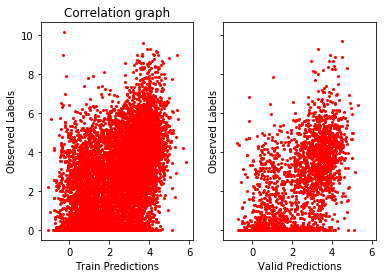

In [46]:
linreg_more = LinearRegression()
linreg_more.fit(x_train, np.arcsinh(y_train_regression_labels))
linreg_more_preds, _ = evaluate(linreg_more, x_train, y_train_regression_labels, x_valid, y_valid_regression_labels, 'ABC.weighted_deepsea_predicted_H3K27ac', 'constantEnhancerPromoter_DeepseaMoreAccessibilityTasks')


In [47]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {#'n_estimators': 100,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_more = RandomForestRegressor(n_estimators=32)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_more = RandomizedSearchCV(estimator = rf_more, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 20)
# Fit the random search model
rf_random_more.fit(x_train, np.arcsinh(y_train_regression_labels))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:  1.7min
[Parallel(n_jobs=20)]: Done 122 tasks      | elapsed:  2.6min
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:  3.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=32, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=20,
          param_distributions={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'max_features': ['auto', 'sqrt'], 'min_samples_split': [2, 5, 10], 'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [48]:
rf_random_more.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2}

Train Spearman R: SpearmanrResult(correlation=0.8216772709147555, pvalue=0.0)
Train Pearson R: (0.8325595530805505, 0.0)
Valid Spearman R: SpearmanrResult(correlation=0.7408219296191318, pvalue=0.0)
Valid Pearson R: (0.7303476926389071, 0.0)
Model Performance
MSError: 1.9606 


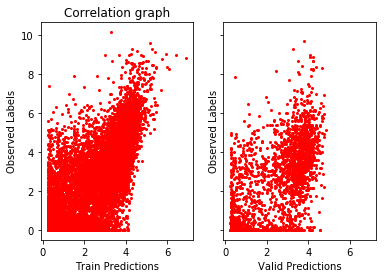

In [50]:
rf_random_more = RandomForestRegressor(n_estimators=32, bootstrap=False, max_depth = 10, max_features='sqrt', min_samples_leaf=4, min_samples_split=2)
rf_random_more.fit(x_train, np.arcsinh(y_train_regression_labels))
rf_random_more_preds, _ = evaluate(rf_random_more, x_train, y_train_regression_labels, x_valid, y_valid_regression_labels, 'ABC.weighted_deepsea_predicted_H3K27ac', 'constantEnhancerPromoter_DeepseaMoreAccessibilityTasks')